In [7]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [8]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [9]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [10]:
qfl_factors = qfl_quality # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [11]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [12]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [13]:
qfl_df = df

In [14]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_ACCRUALS_BS(0),QFL_ACCRUALS_CF(0),QFL_CASH_GEN_PWR(0),QFL_EFDR(0),QFL_EFR(0),QFL_OCF_EARNINGS(0),QFL_OCF_EARNINGS_VAR(0),QFL_DPS_VAR(0),QFL_ACCUM_DEPR_RATIO(0),QFL_ASSET_LIFE(0),QFL_DFD_REV_CHG_SALES(0),QFL_AR_CHG_SALES(0),QFL_DFD_TAX_CHG_SALES(0),QFL_PREP_EXP_CHG_SALES(0),QFL_INTANG_CHG_SALES(0),QFL_CASH_REV_SALES(0),QFL_AR_SALES(0),QFL_DFD_TAX_SALES(0),QFL_PREP_EXP_SALES(0),QFL_INTANG_SALES(0),"QFL_PREP_EXP_INVEN(0,LEVEL)","QFL_PREP_EXP_INVEN(0,CHANGE)","QFL_FG_INVEN(0,LEVEL)","QFL_FG_INVEN(0,CHANGE)","QFL_BDEBT_AR(0,LEVEL)","QFL_BDEBT_AR(0,CHANGE)","QFL_MIN_INT_EQ(0,LEVEL)","QFL_MIN_INT_EQ(0,CHANGE)",QFL_SALES_STABILITY(0),QFL_EBIT_STABILITY(0),QFL_EBITDA_STABILITY(0),QFL_OCF_STABILITY(0),QFL_FCF_STABILITY(0),QFL_EPS_STABILITY(0),QFL_NET_INC_STABILITY(0),QFL_GROSS_MGN_STABILITY(0),QFL_EBIT_MGN_STABILITY(0),QFL_EBITDA_MGN_STABILITY(0),QFL_OCF_MGN_STABILITY(0),QFL_FCF_MGN_STABILITY(0),QFL_PTX_MGN_STABILITY(0),QFL_NET_MGN_STABILITY(0),"QFL_PIOTROSKI_F(0,ROA)","QFL_PIOTROSKI_F(0,ROA_CHG)","QFL_PIOTROSKI_F(0,CFO)","QFL_PIOTROSKI_F(0,ACCRUAL)","QFL_PIOTROSKI_F(0,MARGIN_CHG)","QFL_PIOTROSKI_F(0,TURN_CHG)","QFL_PIOTROSKI_F(0,LEVER_CHG)","QFL_PIOTROSKI_F(0,LIQUID_CHG)","QFL_PIOTROSKI_F(0,EQ_OFFER)",QFL_PIOTROSKI_F(0),"QFL_BENEISH_M(0,DSRI)","QFL_BENEISH_M(0,GMI)","QFL_BENEISH_M(0,AQI)","QFL_BENEISH_M(0,SGI)","QFL_BENEISH_M(0,DEPI)","QFL_BENEISH_M(0,SGAI)","QFL_BENEISH_M(0,LVGI)","QFL_BENEISH_M(0,TATA)",QFL_BENEISH_M(0),"QFL_ALTMAN_Z(0,X1)","QFL_ALTMAN_Z(0,X2)","QFL_ALTMAN_Z(0,X3)","QFL_ALTMAN_Z(0,X4)","QFL_ALTMAN_Z(0,X5)",QFL_ALTMAN_Z(0)
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,-1.324638,-19.084040,0.369847,-0.294244,-0.517136,1.405201,0.076776,0.148912,0.595561,4.100579,0.004089,-0.024826,NaN,NaN,NaN,1.028915,0.058800,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.0,0.0,11.882999,18.206644,19.757082,12.370102,8.683401,6.062143,10.857952,133.498350,17.864166,17.009910,19.802406,15.859110,14.831958,32.152170,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,7.0,0.950279,0.990645,1.018868,1.054553,0.798388,1.064003,1.124089,-0.070891,-2.882144,0.118316,0.046207,0.199111,7.666787,0.835433,6.299241
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,21.217370,-4.614842,0.415048,-0.146664,-0.373098,1.393633,0.537443,0.131032,0.443564,5.217399,0.015491,0.025586,-0.000319,NaN,0.008103,0.989906,0.155329,0.001271,NaN,0.345399,NaN,NaN,0.675046,-0.057982,0.026001,0.010374,0.0,0.0,4.875520,2.605282,2.887545,4.422132,4.588669,1.451108,1.497250,25.217669,5.039925,6.013425,16.654833,12.367548,4.786670,2.844990,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,8.0,1.008459,0.973946,0.929395,1.135446,0.892149,0.958112,0.962164,-0.064491,-2.689420,0.355550,0.130209,0.193683,9.161954,0.507461,7.252739
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,24.332981,8.749453,0.494796,0.098476,-0.206078,3.181907,6.984347,NaN,0.324366,6.458482,0.000776,0.011416,NaN,NaN,0.000650,0.978372,0.059081,NaN,NaN,0.042995,NaN,NaN,1.000000,0.000000,0.044971,-0.005225,0.0,0.0,2.740514,1.117816,1.613064,1.526842,1.345189,1.013005,0.991330,13.481634,2.330737,4.454567,6.280461,4.020551,2.112599,1.674056,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,6.0,0.970639,1.022011,0.846384,1.310689,0.865203,0.965704,0.982972,-0.159833,-3.035089,0.039184,0.160639,0.085964,8.040289,1.466792,6.846563
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,36.223390,29.137615,NaN,-0.100282,-0.332764,1.452186,0.406471,NaN,0.214629,8.607321,0.001773,0.004444,-0.015321,NaN,0.007395,0.997328,0.101600,0.045330,NaN,0.250393,NaN,NaN,NaN,NaN,0.037313,-0.000435,0.0,0.0,2.319777,3.074652,3.066902,2.892207,3.210056,2.704802,2.

In [15]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_ACCRUALS_BS(0),QFL_ACCRUALS_CF(0),QFL_CASH_GEN_PWR(0),QFL_EFDR(0),QFL_EFR(0),QFL_OCF_EARNINGS(0),QFL_OCF_EARNINGS_VAR(0),QFL_DPS_VAR(0),QFL_ACCUM_DEPR_RATIO(0),QFL_ASSET_LIFE(0),QFL_DFD_REV_CHG_SALES(0),QFL_AR_CHG_SALES(0),QFL_DFD_TAX_CHG_SALES(0),QFL_PREP_EXP_CHG_SALES(0),QFL_INTANG_CHG_SALES(0),QFL_CASH_REV_SALES(0),QFL_AR_SALES(0),QFL_DFD_TAX_SALES(0),QFL_PREP_EXP_SALES(0),QFL_INTANG_SALES(0),"QFL_PREP_EXP_INVEN(0,LEVEL)","QFL_PREP_EXP_INVEN(0,CHANGE)","QFL_FG_INVEN(0,LEVEL)","QFL_FG_INVEN(0,CHANGE)","QFL_BDEBT_AR(0,LEVEL)","QFL_BDEBT_AR(0,CHANGE)","QFL_MIN_INT_EQ(0,LEVEL)","QFL_MIN_INT_EQ(0,CHANGE)",QFL_SALES_STABILITY(0),QFL_EBIT_STABILITY(0),QFL_EBITDA_STABILITY(0),QFL_OCF_STABILITY(0),QFL_FCF_STABILITY(0),QFL_EPS_STABILITY(0),QFL_NET_INC_STABILITY(0),QFL_GROSS_MGN_STABILITY(0),QFL_EBIT_MGN_STABILITY(0),QFL_EBITDA_MGN_STABILITY(0),QFL_OCF_MGN_STABILITY(0),QFL_FCF_MGN_STABILITY(0),QFL_PTX_MGN_STABILITY(0),QFL_NET_MGN_STABILITY(0),"QFL_PIOTROSKI_F(0,ROA)","QFL_PIOTROSKI_F(0,ROA_CHG)","QFL_PIOTROSKI_F(0,CFO)","QFL_PIOTROSKI_F(0,ACCRUAL)","QFL_PIOTROSKI_F(0,MARGIN_CHG)","QFL_PIOTROSKI_F(0,TURN_CHG)","QFL_PIOTROSKI_F(0,LEVER_CHG)","QFL_PIOTROSKI_F(0,LIQUID_CHG)","QFL_PIOTROSKI_F(0,EQ_OFFER)",QFL_PIOTROSKI_F(0),"QFL_BENEISH_M(0,DSRI)","QFL_BENEISH_M(0,GMI)","QFL_BENEISH_M(0,AQI)","QFL_BENEISH_M(0,SGI)","QFL_BENEISH_M(0,DEPI)","QFL_BENEISH_M(0,SGAI)","QFL_BENEISH_M(0,LVGI)","QFL_BENEISH_M(0,TATA)",QFL_BENEISH_M(0),"QFL_ALTMAN_Z(0,X1)","QFL_ALTMAN_Z(0,X2)","QFL_ALTMAN_Z(0,X3)","QFL_ALTMAN_Z(0,X4)","QFL_ALTMAN_Z(0,X5)",QFL_ALTMAN_Z(0)
1595,890100,30-Nov-2020,BZ22BK,0.002738,SmartCentres Real Estate Investment Trust,Real Estate,Canada,-3.552645,Mid Cap,2688.3582,2.236403,1.701837,0.177990,0.031326,0.011694,2.757954,0.076317,0.042660,0.241768,2.094737,NaN,NaN,NaN,NaN,-0.001654,NaN,NaN,NaN,NaN,0.058112,NaN,NaN,NaN,NaN,NaN,NaN,0.164253,0.000809,19.164705,6.319119,6.349889,16.075052,16.221601,4.659447,4.933394,36.795570,5.991804,6.022208,28.033127,27.895721,4.282768,4.673547,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,1.000000,1.051425,1.000000,0.990872,1.019793,1.185604,1.000000,-0.021091,-2.589701,0.000000,0.120926,0.049076,0.822754,0.079386,0.904285
1596,890100,30-Nov-2020,B2NT8S,0.002637,"Seven Bank, Ltd.",Financials,Japan,-4.803491,Mid Cap,2619.2988,NaN,NaN,0.808956,-0.166663,-0.161764,4.775476,1.735814,0.110170,NaN,1.131075,NaN,NaN,-0.001958,NaN,0.036746,NaN,NaN,-0.005506,NaN,0.230288,NaN,NaN,NaN,NaN,NaN,NaN,0.006545,0.005022,10.869376,7.359196,11.139915,0.786849,0.605555,4.720225,4.748840,NaN,6.009900,6.617759,0.973138,0.755860,5.982594,4.270490,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,6.0,1.000000,1.000000,0.918848,0.952491,0.963114,1.000000,0.989628,-0.088674,-2.972514,0.365195,0.142953,0.034509,0.302265,0.124810,1.058418
1597,890100,30-Nov-2020,BKSLS5,0.002617,First Capital Real Estate Investment Trust,Real Estate,Canada,-12.513375,Mid Cap,2634.8494,-3.530244,-4.119935,0.115366,-0.080727,-0.076600,1.498939,0.381572,0.070756,0.572057,2.074635,-0.002082,NaN,-0.212741,NaN,0.000000,NaN,NaN,0.978601,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.006935,-0.004779,22.428352,2.938703,2.974871,6.092854,5.340309,2.466595,2.417955,54.330990,2.716225,2.747311,5.807560,5.130810,1.924593,2.249123,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.000000,1.036746,1.000000,0.912926,1.345220,0.729462,1.000000,-0.007718,-2.488288,0.000000,0.138418,0.036943,0.613269,0.067127,0.750786
1598,890100,30-Nov-2020,659844,0.002463,Mitsubishi Motors Corporation,Consumer Discretionary,Japan,15.425528,Mid Cap,2808.4746,-9.591725,9.411576,0.144937,-0.046938,-0.004727,NaN,0.934507,0.228861,0.651961,NaN,NaN,-0.023791,0.001823,NaN,-0.006143,1.022157,0.065672,-0.015247,NaN,0.018243,NaN,NaN,0.669686,-0.039563,0.010286,0.001440,0.024152,0.013537,9.560201,0.654524,1.144056,1.209923,0.233255,0.449948,0.521912,9.058861,0.534653,1.033447,1.233995,0.199413,0.509070,0.4903

In [16]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,QFL_ACCRUALS_BS(0),QFL_ACCRUALS_CF(0),QFL_CASH_GEN_PWR(0),QFL_EFDR(0),QFL_EFR(0),QFL_OCF_EARNINGS(0),QFL_OCF_EARNINGS_VAR(0),QFL_DPS_VAR(0),QFL_ACCUM_DEPR_RATIO(0),QFL_ASSET_LIFE(0),QFL_DFD_REV_CHG_SALES(0),QFL_AR_CHG_SALES(0),QFL_DFD_TAX_CHG_SALES(0),QFL_PREP_EXP_CHG_SALES(0),QFL_INTANG_CHG_SALES(0),QFL_CASH_REV_SALES(0),QFL_AR_SALES(0),QFL_DFD_TAX_SALES(0),QFL_PREP_EXP_SALES(0),QFL_INTANG_SALES(0),"QFL_PREP_EXP_INVEN(0,LEVEL)","QFL_PREP_EXP_INVEN(0,CHANGE)","QFL_FG_INVEN(0,LEVEL)","QFL_FG_INVEN(0,CHANGE)","QFL_BDEBT_AR(0,LEVEL)","QFL_BDEBT_AR(0,CHANGE)","QFL_MIN_INT_EQ(0,LEVEL)","QFL_MIN_INT_EQ(0,CHANGE)",QFL_SALES_STABILITY(0),QFL_EBIT_STABILITY(0),QFL_EBITDA_STABILITY(0),QFL_OCF_STABILITY(0),QFL_FCF_STABILITY(0),QFL_EPS_STABILITY(0),QFL_NET_INC_STABILITY(0),QFL_GROSS_MGN_STABILITY(0),QFL_EBIT_MGN_STABILITY(0),QFL_EBITDA_MGN_STABILITY(0),QFL_OCF_MGN_STABILITY(0),QFL_FCF_MGN_STABILITY(0),QFL_PTX_MGN_STABILITY(0),QFL_NET_MGN_STABILITY(0),"QFL_PIOTROSKI_F(0,ROA)","QFL_PIOTROSKI_F(0,ROA_CHG)","QFL_PIOTROSKI_F(0,CFO)","QFL_PIOTROSKI_F(0,ACCRUAL)","QFL_PIOTROSKI_F(0,MARGIN_CHG)","QFL_PIOTROSKI_F(0,TURN_CHG)","QFL_PIOTROSKI_F(0,LEVER_CHG)","QFL_PIOTROSKI_F(0,LIQUID_CHG)","QFL_PIOTROSKI_F(0,EQ_OFFER)",QFL_PIOTROSKI_F(0),"QFL_BENEISH_M(0,DSRI)","QFL_BENEISH_M(0,GMI)","QFL_BENEISH_M(0,AQI)","QFL_BENEISH_M(0,SGI)","QFL_BENEISH_M(0,DEPI)","QFL_BENEISH_M(0,SGAI)","QFL_BENEISH_M(0,LVGI)","QFL_BENEISH_M(0,TATA)",QFL_BENEISH_M(0),"QFL_ALTMAN_Z(0,X1)","QFL_ALTMAN_Z(0,X2)","QFL_ALTMAN_Z(0,X3)","QFL_ALTMAN_Z(0,X4)","QFL_ALTMAN_Z(0,X5)",QFL_ALTMAN_Z(0)
count,1600.0,1600.000000,1597.000000,1.598000e+03,1565.000000,1567.000000,1493.000000,1593.000000,1596.000000,1469.000000,1492.000000,1381.000000,1349.000000,1242.000000,822.000000,1248.000000,1482.000000,452.000000,1542.000000,1248.000000,1251.000000,1492.000000,484.000000,1549.000000,402.000000,376.000000,1027.000000,1015.000000,1046.000000,998.000000,1569.000000,1558.000000,1595.000000,1595.000000,1595.000000,1594.000000,1591.000000,1593.000000,1595.000000,1396.000000,1594.000000,1594.000000,1594.000000,1591.000000,1594.000000,1594.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1596.000000,1598.000000,1596.000000,1596.000000
mean,890100.0,0.062500,3.118575,3.489420e+04,2.136701,13.653327,0.539113,-0.024718,-0.091702,7.397946,2.726636,0.256168,0.452055,9.355782,0.018115,-0.005552,0.005765,0.001872,0.034054,1.010796,0.166089,0.135497,0.020125,0.536840,1.232609,-0.439313,0.473734,0.001302,0.045770,0.007475,0.044802,-0.006755,12.825103,4.932275,6.118091,4.840404,2.843593,3.529505,3.607717,28.857591,6.913911,9.524570,6.259753,3.414975,6.086126,4.727740,0.819775,0.292240,0.946183,0.885482,0.346058,0.155820,0.380476,0.585106,0.599499,5.010638,1.040769,1.123768,1.011754,1.004685,1.060761,1.046678,1.041879,-0.050500,-2.620148,0.102459,0.224286,0.064737,5.596665,0.568416,4.578217
std,0.0,0.177252,7.256757,9.150908e+04,177.940496,438.769195,0.294224,0.170756,0.148452,88.289573,15.284238,0.324622,0.156148,9.289641,0.209716,0.070824,0.159301,0.012636,0.386908,0.143078,0.143441,2.324127,0.045710,0.895017,6.550701,7.237295,0.321531,0.072903,0.083905,0.049322,0.109422,0.189022,11.454125,4.653677,5.602244,4.511351,4.073356,3.494014,3.523345,32.546006,7.494993,9.575611,5.395929,3.829500,7.031576,5.335024,0.384495,0.454935,0.225727,0.318539,0.475861,0.362798,0.485656,0.492858,0.490153,1.467412,0.227736,0.577340,0.305245,0.284277,0.401843,0.323445,0.259246,0.060840,0.513446,0.198979,0.413845,0.079088,16.953609,0.490044,10.411951
min,890100.0,0.002419,-31.602722,2.063382e+03,-4890.864700,-4929.896000,0.000088,-2.982245,-1.515920,-35.071674,0.026325,0.000000,0.012565,0.000000,-0.747687,-1.340539,-0.657167,-0.040545,-1.592892,0.269335,0.000000,-0.759414,0.

In [17]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID          0
DATE                  0
SECURITY_ID           0
Weight                0
proper_name           0
                     ..
QFL_ALTMAN_Z(0,X2)    2
QFL_ALTMAN_Z(0,X3)    4
QFL_ALTMAN_Z(0,X4)    2
QFL_ALTMAN_Z(0,X5)    4
QFL_ALTMAN_Z(0)       4
Length: 77, dtype: int64

In [18]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if idx > 9 and qfl_df[col].count() > 0 and qfl_df[col].sum() > 0 and qfl_df[col].values.dtype == 'float64']

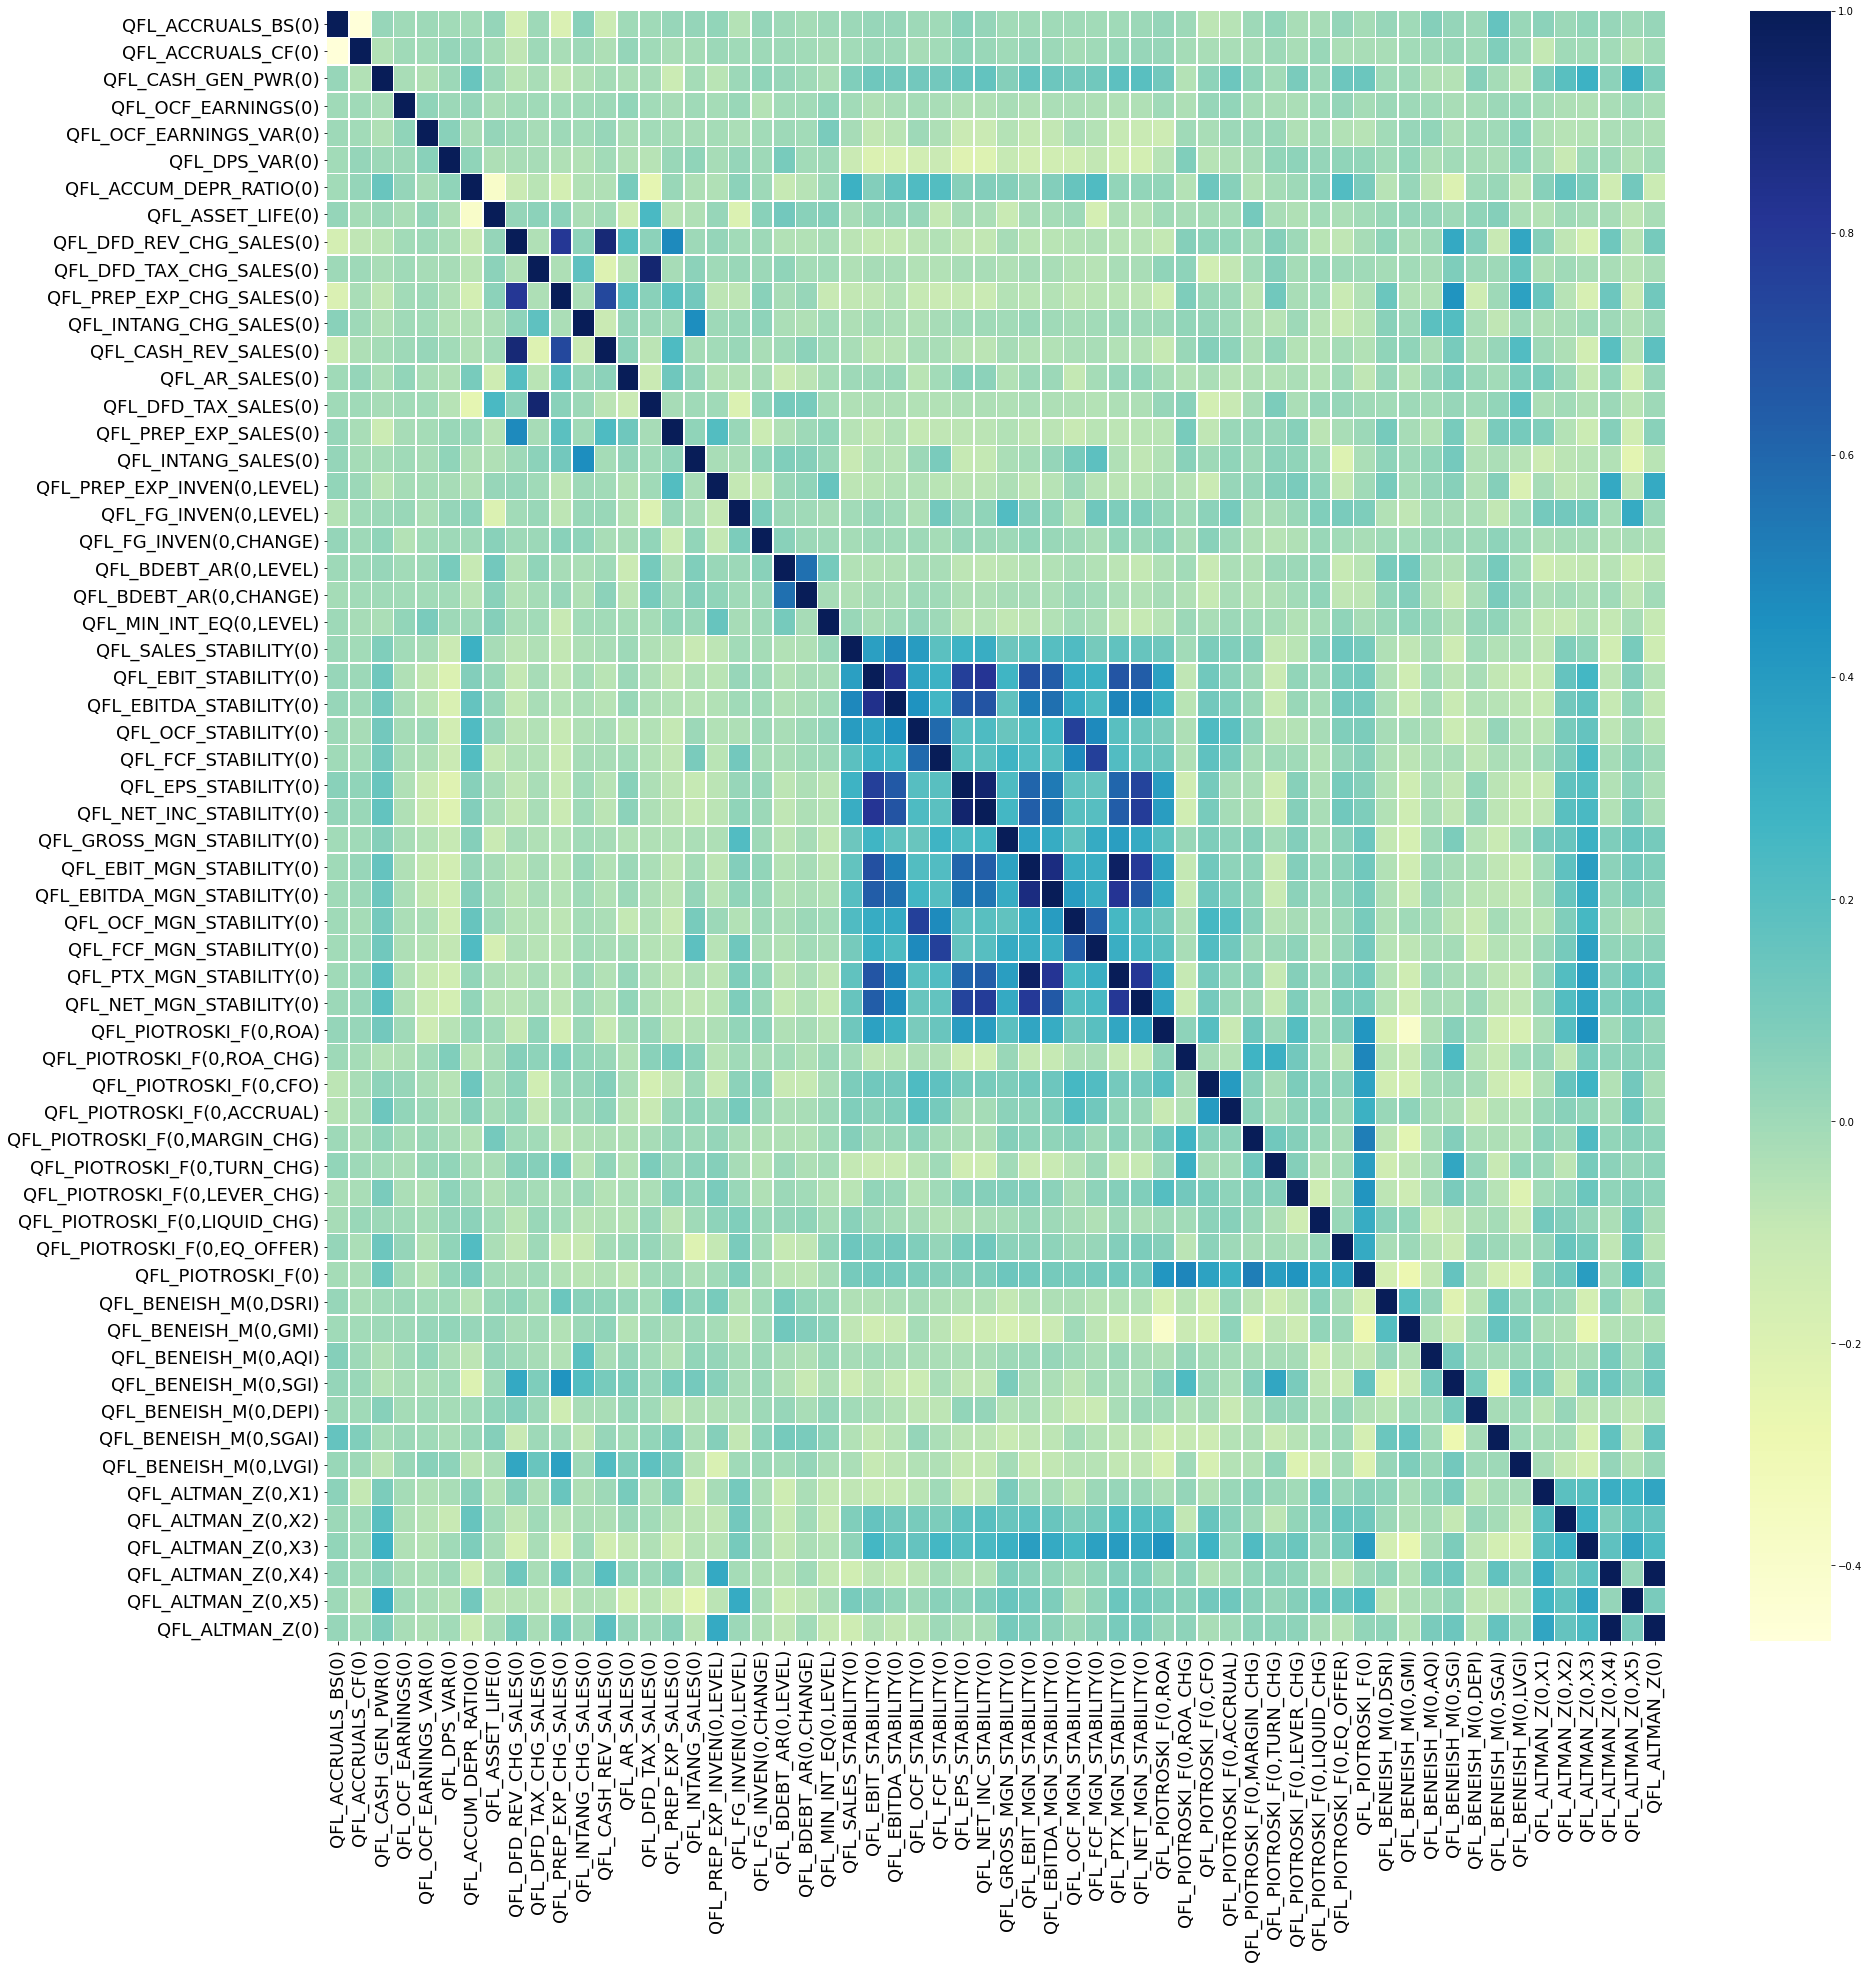

In [19]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

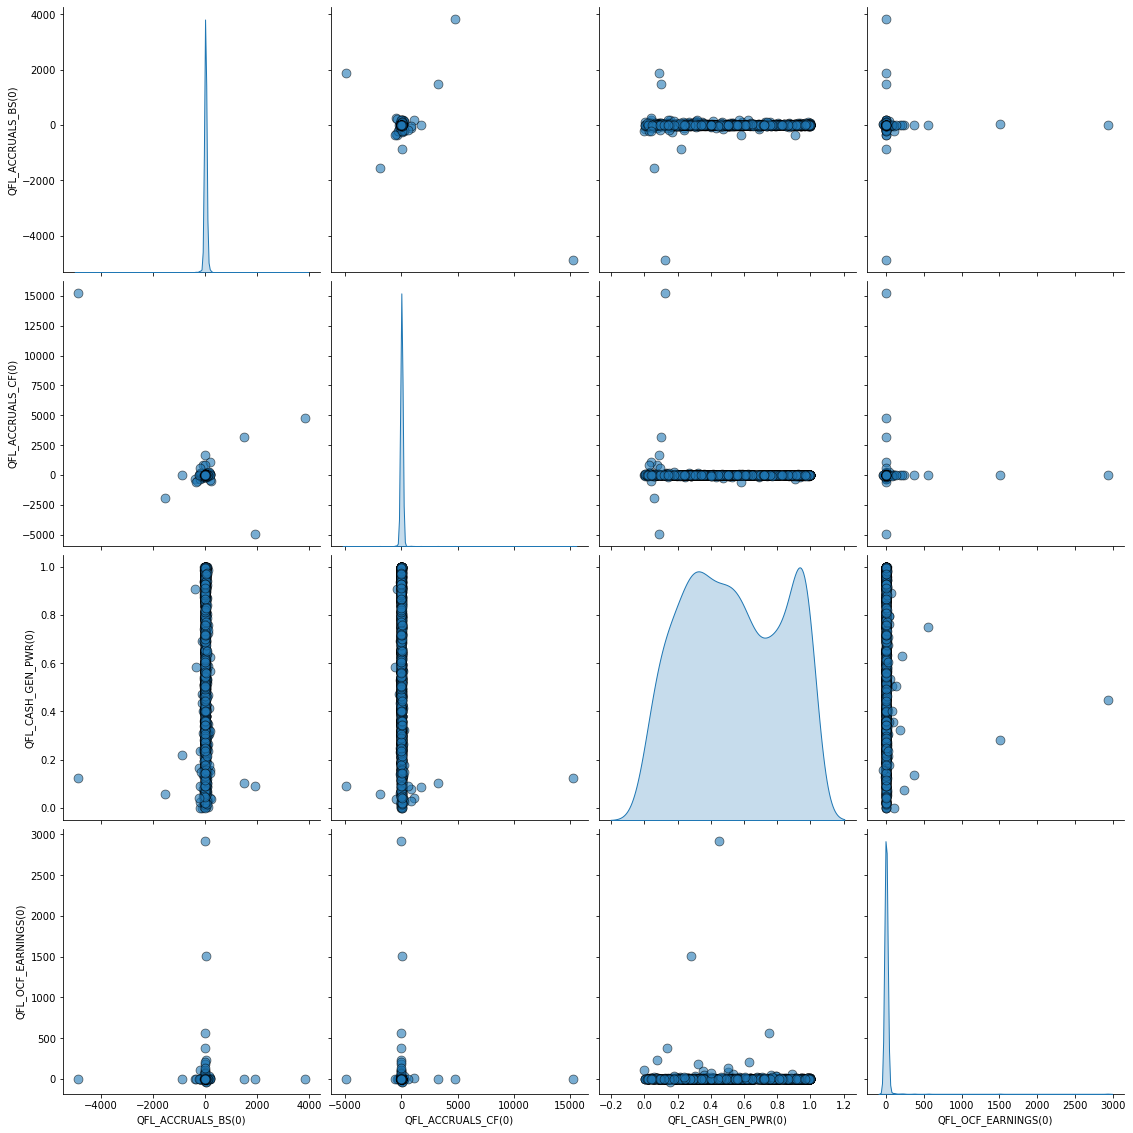

In [20]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [21]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,QFL_ACCRUALS_BS(0),QFL_ACCRUALS_CF(0),QFL_CASH_GEN_PWR(0),QFL_OCF_EARNINGS(0)
0,-1.324638,-19.084040,0.369847,1.405201
1,21.217370,-4.614842,0.415048,1.393633
2,24.332981,8.749453,0.494796,3.181907
3,36.223390,29.137615,NaN,1.452186
4,20.330269,9.035897,0.294898,1.592529
...,...,...,...,...
1595,2.236403,1.701837,0.177990,2.757954
1596,NaN,NaN,0.808956,4.775476
1597,-3.530244,-4.119935,0.115366,1.498939
1598,-9.591725,9.411576,0.144937,NaN


In [22]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
QFL_ACCRUALS_BS(0),1565,"[-4890.86, 3837.45]",2.14,31662.8,-6.29,516.33
QFL_ACCRUALS_CF(0),1567,"[-4929.9, 15252.18]",13.65,192518,26.9,947.93
QFL_CASH_GEN_PWR(0),1493,"[0.0, 1.0]",0.54,0.09,0.03,-1.21
QFL_OCF_EARNINGS(0),1469,"[-35.07, 2925.0]",7.4,7795.05,28.17,867.71
QFL_OCF_EARNINGS_VAR(0),1492,"[0.03, 477.75]",2.73,233.61,22.56,645.67
QFL_DPS_VAR(0),1381,"[0.0, 4.12]",0.26,0.11,5.05,41.45
QFL_ACCUM_DEPR_RATIO(0),1349,"[0.01, 0.82]",0.45,0.02,-0.27,-0.45
QFL_ASSET_LIFE(0),1242,"[0.0, 165.25]",9.36,86.3,7.27,90.52
QFL_DFD_REV_CHG_SALES(0),822,"[-0.75, 4.98]",0.02,0.04,17.96,395.95
QFL_DFD_TAX_CHG_SALES(0),1482,"[-0.66, 3.95]",0.01,0.03,20.54,505.24


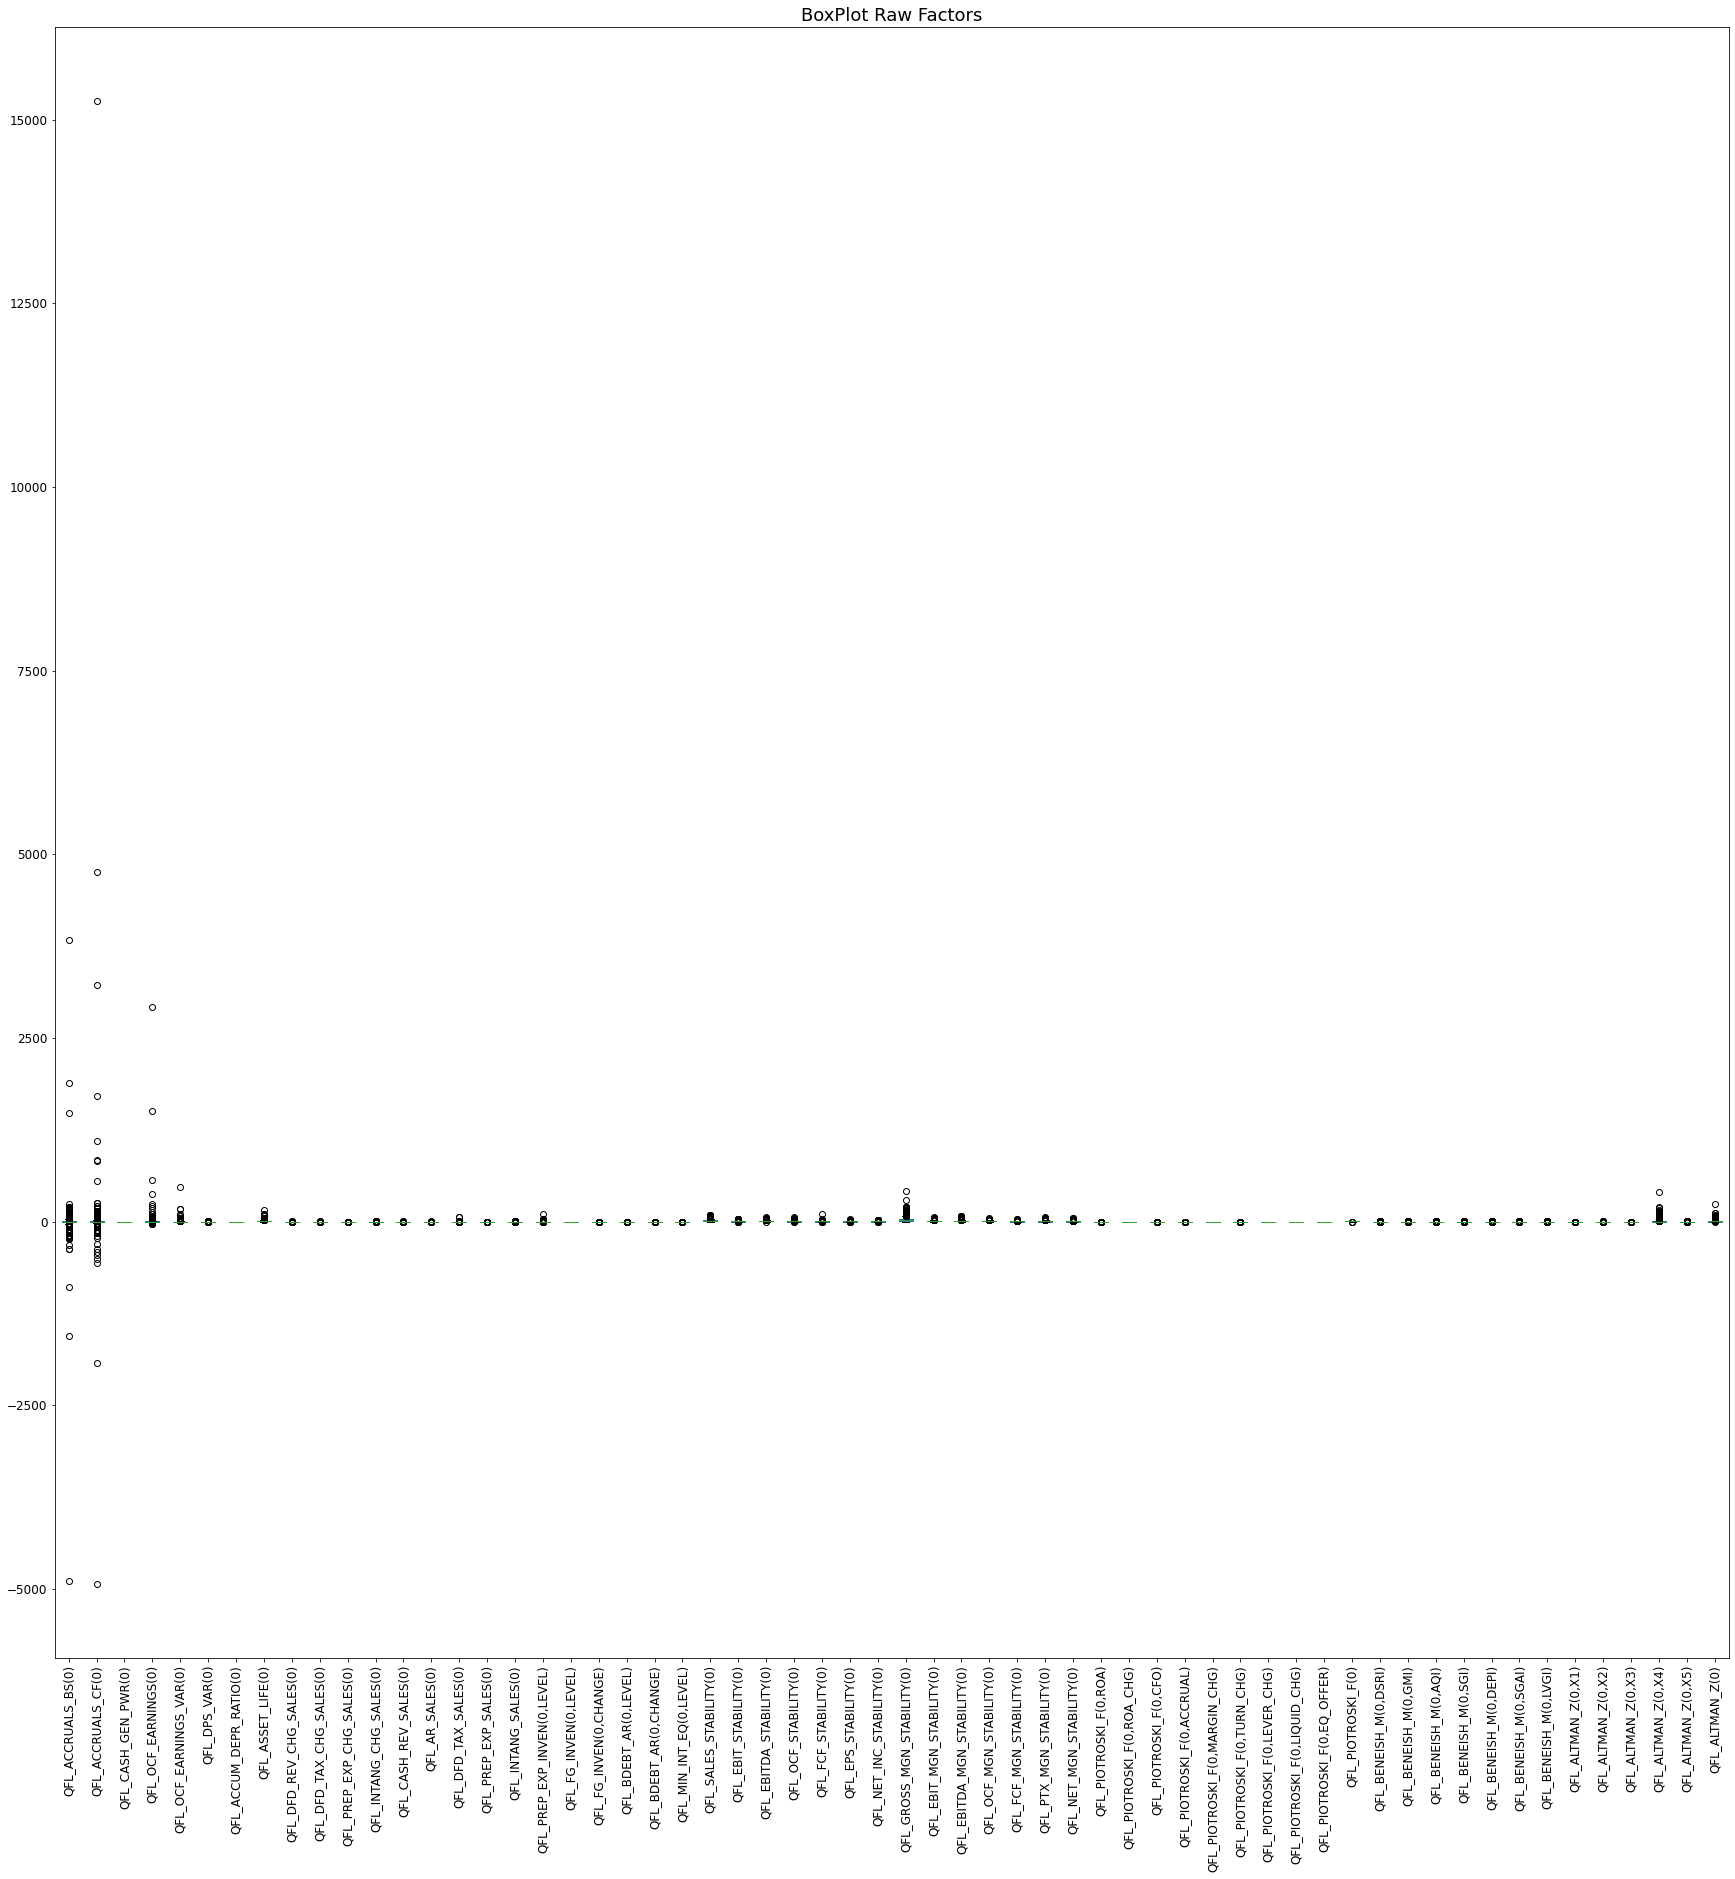

In [23]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [24]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,QFL_ACCRUALS_BS(0),QFL_ACCRUALS_CF(0),QFL_CASH_GEN_PWR(0),QFL_OCF_EARNINGS(0),QFL_OCF_EARNINGS_VAR(0),QFL_DPS_VAR(0),QFL_ACCUM_DEPR_RATIO(0),QFL_ASSET_LIFE(0),QFL_DFD_REV_CHG_SALES(0),QFL_DFD_TAX_CHG_SALES(0),QFL_PREP_EXP_CHG_SALES(0),QFL_INTANG_CHG_SALES(0),QFL_CASH_REV_SALES(0),QFL_AR_SALES(0),QFL_DFD_TAX_SALES(0),QFL_PREP_EXP_SALES(0),QFL_INTANG_SALES(0),"QFL_PREP_EXP_INVEN(0,LEVEL)","QFL_FG_INVEN(0,LEVEL)","QFL_FG_INVEN(0,CHANGE)","QFL_BDEBT_AR(0,LEVEL)","QFL_BDEBT_AR(0,CHANGE)","QFL_MIN_INT_EQ(0,LEVEL)",QFL_SALES_STABILITY(0),QFL_EBIT_STABILITY(0),QFL_EBITDA_STABILITY(0),QFL_OCF_STABILITY(0),QFL_FCF_STABILITY(0),QFL_EPS_STABILITY(0),QFL_NET_INC_STABILITY(0),QFL_GROSS_MGN_STABILITY(0),QFL_EBIT_MGN_STABILITY(0),QFL_EBITDA_MGN_STABILITY(0),QFL_OCF_MGN_STABILITY(0),QFL_FCF_MGN_STABILITY(0),QFL_PTX_MGN_STABILITY(0),QFL_NET_MGN_STABILITY(0),"QFL_PIOTROSKI_F(0,ROA)","QFL_PIOTROSKI_F(0,ROA_CHG)","QFL_PIOTROSKI_F(0,CFO)","QFL_PIOTROSKI_F(0,ACCRUAL)","QFL_PIOTROSKI_F(0,MARGIN_CHG)","QFL_PIOTROSKI_F(0,TURN_CHG)","QFL_PIOTROSKI_F(0,LEVER_CHG)","QFL_PIOTROSKI_F(0,LIQUID_CHG)","QFL_PIOTROSKI_F(0,EQ_OFFER)",QFL_PIOTROSKI_F(0),"QFL_BENEISH_M(0,DSRI)","QFL_BENEISH_M(0,GMI)","QFL_BENEISH_M(0,AQI)","QFL_BENEISH_M(0,SGI)","QFL_BENEISH_M(0,DEPI)","QFL_BENEISH_M(0,SGAI)","QFL_BENEISH_M(0,LVGI)","QFL_ALTMAN_Z(0,X1)","QFL_ALTMAN_Z(0,X2)","QFL_ALTMAN_Z(0,X3)","QFL_ALTMAN_Z(0,X4)","QFL_ALTMAN_Z(0,X5)",QFL_ALTMAN_Z(0)
count,1.565000e+03,1.567000e+03,1.493000e+03,1.469000e+03,1.492000e+03,1.381000e+03,1.349000e+03,1.242000e+03,8.220000e+02,1.482000e+03,4.520000e+02,1.542000e+03,1.248000e+03,1.251000e+03,1.492000e+03,4.840000e+02,1.549000e+03,4.020000e+02,1.027000e+03,1.015000e+03,1.046000e+03,9.980000e+02,1.569000e+03,1.595000e+03,1.595000e+03,1.595000e+03,1.594000e+03,1.591000e+03,1.593000e+03,1.595000e+03,1.396000e+03,1.594000e+03,1.594000e+03,1.594000e+03,1.591000e+03,1.594000e+03,1.594000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.596000e+03,1.598000e+03,1.596000e+03,1.596000e+03
mean,6.432887e-18,-1.290803e-17,-1.395698e-15,2.637630e-17,1.028742e-16,4.654335e-16,1.316795e-15,-4.737667e-16,-5.944488e-17,2.616834e-17,-1.221982e-17,1.101403e-16,5.180996e-15,-6.900955e-16,3.960564e-17,2.259441e-16,1.966722e-16,-5.302558e-17,9.366628e-16,-6.464451e-17,1.158570e-15,-2.308329e-17,2.221331e-16,-3.262350e-15,-1.581842e-15,-5.132084e-16,1.672125e-15,-1.118440e-15,-1.466620e-16,-2.303104e-16,-6.641456e-16,1.128889e-15,7.449081e-16,-1.716876e-16,4.383148e-16,6.441592e-16,1.611948e-15,2.052662e-16,-2.608121e-16,9.863824e-16,-1.674366e-15,6.627990e-17,2.522666e-16,1.707715e-16,-5.763711e-16,1.245145e-15,-4.803599e-19,-2.298849e-15,1.589849e-15,-3.605098e-16,-3.370288e-15,-1.757668e-15,-5.465938e-15,3.983602e-15,1.874457e-16,-1.425643e-16,5.201388e-16,-4.386614e-16,1.265226e-15,-1.075787e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.749796e+01,-1.126686e+01,-1.832020e+00,-4.810265e-01,-1.766729e-01,-7.891276e-01,-2.814571e+00,-1.007120e+00,-3.651615e+00,-4.161513e+00,-3.356771e+00,-4.204998e+00,-5.182199e+00,-1.157886

In [25]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,QFL_ACCRUALS_BS(0),QFL_ACCRUALS_CF(0),QFL_CASH_GEN_PWR(0),QFL_OCF_EARNINGS(0),QFL_OCF_EARNINGS_VAR(0),QFL_DPS_VAR(0),QFL_ACCUM_DEPR_RATIO(0),QFL_ASSET_LIFE(0),QFL_DFD_REV_CHG_SALES(0),QFL_DFD_TAX_CHG_SALES(0),QFL_PREP_EXP_CHG_SALES(0),QFL_INTANG_CHG_SALES(0),QFL_CASH_REV_SALES(0),QFL_AR_SALES(0),QFL_DFD_TAX_SALES(0),QFL_PREP_EXP_SALES(0),QFL_INTANG_SALES(0),"QFL_PREP_EXP_INVEN(0,LEVEL)","QFL_FG_INVEN(0,LEVEL)","QFL_FG_INVEN(0,CHANGE)","QFL_BDEBT_AR(0,LEVEL)","QFL_BDEBT_AR(0,CHANGE)","QFL_MIN_INT_EQ(0,LEVEL)",QFL_SALES_STABILITY(0),QFL_EBIT_STABILITY(0),QFL_EBITDA_STABILITY(0),QFL_OCF_STABILITY(0),QFL_FCF_STABILITY(0),QFL_EPS_STABILITY(0),QFL_NET_INC_STABILITY(0),QFL_GROSS_MGN_STABILITY(0),QFL_EBIT_MGN_STABILITY(0),QFL_EBITDA_MGN_STABILITY(0),QFL_OCF_MGN_STABILITY(0),QFL_FCF_MGN_STABILITY(0),QFL_PTX_MGN_STABILITY(0),QFL_NET_MGN_STABILITY(0),"QFL_PIOTROSKI_F(0,ROA)","QFL_PIOTROSKI_F(0,ROA_CHG)","QFL_PIOTROSKI_F(0,CFO)","QFL_PIOTROSKI_F(0,ACCRUAL)","QFL_PIOTROSKI_F(0,MARGIN_CHG)","QFL_PIOTROSKI_F(0,TURN_CHG)","QFL_PIOTROSKI_F(0,LEVER_CHG)","QFL_PIOTROSKI_F(0,LIQUID_CHG)","QFL_PIOTROSKI_F(0,EQ_OFFER)",QFL_PIOTROSKI_F(0),"QFL_BENEISH_M(0,DSRI)","QFL_BENEISH_M(0,GMI)","QFL_BENEISH_M(0,AQI)","QFL_BENEISH_M(0,SGI)","QFL_BENEISH_M(0,DEPI)","QFL_BENEISH_M(0,SGAI)","QFL_BENEISH_M(0,LVGI)","QFL_ALTMAN_Z(0,X1)","QFL_ALTMAN_Z(0,X2)","QFL_ALTMAN_Z(0,X3)","QFL_ALTMAN_Z(0,X4)","QFL_ALTMAN_Z(0,X5)",QFL_ALTMAN_Z(0)
0,21.553907,34.730168,1.566448,33.045828,31.079523,11.912132,2.333034,16.781511,23.661084,24.749672,16.758080,24.458129,29.568003,14.838176,27.176280,18.454833,12.766378,16.680257,2.258776,12.665018,11.372205,19.854984,15.581921,7.371849,7.291070,10.686930,11.922028,25.471360,9.056422,6.178045,11.835828,7.673970,7.587953,8.873678,7.963861,7.624877,7.202067,0.468732,1.555740,0.238417,0.35951,1.374231,2.326861,1.275645,0.841812,0.817093,2.718637,17.385203,6.713951,13.065700,14.054306,9.802922,12.222550,15.267806,4.475940,5.671622,6.189196,23.744651,8.218955,23.176320
1,10.626694,10.810593,1.566448,16.964777,11.170905,11.912132,2.325144,10.737966,9.988141,24.749672,4.777977,18.365298,9.125494,10.947107,27.176280,5.096207,9.076324,6.134192,2.250848,9.358114,8.521644,11.622153,10.431105,6.893560,6.014234,8.705114,11.307024,9.038969,5.793099,6.163524,8.219855,5.450464,7.452724,5.951831,7.347075,6.975191,7.176316,0.468732,1.555740,0.238417,0.35951,1.374231,2.326861,1.275645,0.841812,0.817093,2.718637,12.020035,6.713951,13.065700,14.054306,9.802922,12.222550,13.878910,3.857931,5.100191,5.527273,11.259119,6.796175,10.940890
2,8.286130,7.322859,1.566448,6.298787,10.708083,9.246793,2.286021,10.215821,7.348478,4.165743,4.222038,9.841213,6.229573,9.696958,1.014486,4.446195,7.798523,4.293735,1.830490,9.358114,8.025845,7.744311,8.822938,6.251677,5.811533,7.447008,8.399897,5.294408,5.455763,5.157561,5.433959,5.302992,6.689830,5.829177,6.392674,6.866880,6.405350,0.468732,1.555740,0.238417,0.35951,1.374231,2.326861,1.275645,0.841812,0.817093,2.718637,8.267817,6.713951,13.065700,10.351466,9.802922,12.222550,12.848670,3.756091,4.939880,5.425550,10.423413,6.580008,10.334080
3,1.315762,3.879917,1.566448,4.166969,6.999707,7.439059,2.260519,9.128938,3.929357,3.319620,3.981224,9.522827,5.546193,9.554098,0.868819,3.596839,6.990546,3.646180,1.762773,8.828933,8.015929,5.581049,7.387040,5.923697,5.558923,6.929804,5.900265,5.080156,5.159838,5.008346,5.372303,5.236191,5.954991,5.505878,5.484210,6.207474,6.231283,0.468732,1.555740,0.238417,0.35951,1.374231,2.326861,1.275645,0.841812,0.817093,2.718637,8.072600,6.713951,13.065700,7.121694,9.802922,10.778564,8.687622,3.689773,4.413570,5.220942,9.021592,6.359640,8.715255
4,1.108774,2.483840,1.566448,2.588028,5.188145,7.303483,2.253449,6.921809,3.842792,3.218654,2.779051,5.964094,4.170885,7.039063,0.667480,3.173058,6.904874,3.241130,1.636751,8.051972,7.402091,5.237026,6.736613,5.652393,5.325447,6.250367,5.058536,4.856465,4.744227,4.808112,5.268757,5.164686,5.625440,5.170012,5.396517,5.190508,5.140452,0.468732,1.555740,0

In [26]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,QFL_ACCRUALS_BS(0),QFL_ACCRUALS_CF(0),QFL_CASH_GEN_PWR(0),QFL_OCF_EARNINGS(0),QFL_OCF_EARNINGS_VAR(0),QFL_DPS_VAR(0),QFL_ACCUM_DEPR_RATIO(0),QFL_ASSET_LIFE(0),QFL_DFD_REV_CHG_SALES(0),QFL_DFD_TAX_CHG_SALES(0),QFL_PREP_EXP_CHG_SALES(0),QFL_INTANG_CHG_SALES(0),QFL_CASH_REV_SALES(0),QFL_AR_SALES(0),QFL_DFD_TAX_SALES(0),QFL_PREP_EXP_SALES(0),QFL_INTANG_SALES(0),"QFL_PREP_EXP_INVEN(0,LEVEL)","QFL_FG_INVEN(0,LEVEL)","QFL_FG_INVEN(0,CHANGE)","QFL_BDEBT_AR(0,LEVEL)","QFL_BDEBT_AR(0,CHANGE)","QFL_MIN_INT_EQ(0,LEVEL)",QFL_SALES_STABILITY(0),QFL_EBIT_STABILITY(0),QFL_EBITDA_STABILITY(0),QFL_OCF_STABILITY(0),QFL_FCF_STABILITY(0),QFL_EPS_STABILITY(0),QFL_NET_INC_STABILITY(0),QFL_GROSS_MGN_STABILITY(0),QFL_EBIT_MGN_STABILITY(0),QFL_EBITDA_MGN_STABILITY(0),QFL_OCF_MGN_STABILITY(0),QFL_FCF_MGN_STABILITY(0),QFL_PTX_MGN_STABILITY(0),QFL_NET_MGN_STABILITY(0),"QFL_PIOTROSKI_F(0,ROA)","QFL_PIOTROSKI_F(0,ROA_CHG)","QFL_PIOTROSKI_F(0,CFO)","QFL_PIOTROSKI_F(0,ACCRUAL)","QFL_PIOTROSKI_F(0,MARGIN_CHG)","QFL_PIOTROSKI_F(0,TURN_CHG)","QFL_PIOTROSKI_F(0,LEVER_CHG)","QFL_PIOTROSKI_F(0,LIQUID_CHG)","QFL_PIOTROSKI_F(0,EQ_OFFER)",QFL_PIOTROSKI_F(0),"QFL_BENEISH_M(0,DSRI)","QFL_BENEISH_M(0,GMI)","QFL_BENEISH_M(0,AQI)","QFL_BENEISH_M(0,SGI)","QFL_BENEISH_M(0,DEPI)","QFL_BENEISH_M(0,SGAI)","QFL_BENEISH_M(0,LVGI)","QFL_ALTMAN_Z(0,X1)","QFL_ALTMAN_Z(0,X2)","QFL_ALTMAN_Z(0,X3)","QFL_ALTMAN_Z(0,X4)","QFL_ALTMAN_Z(0,X5)",QFL_ALTMAN_Z(0)
0,-27.497964,-11.266856,-1.832020,-0.481026,-0.176673,-0.789128,-2.814571,-1.00712,-3.651615,-4.161513,-3.356771,-4.204998,-5.182199,-1.157886,-0.385053,-0.440269,-0.59981,-0.188164,-1.473373,-7.637343,-0.5455,-9.231790,-1.604509,-1.080832,-2.386465,-2.331790,-2.902619,-2.659536,-3.556996,-2.738306,-0.958304,-1.337741,-1.480461,-1.945467,-1.991275,-1.360157,-1.557452,-2.132080,-0.642379,-4.191705,-2.77982,-0.727224,-0.429495,-0.783427,-1.187171,-1.223086,-3.414608,-4.570074,-10.606867,-3.198815,-5.165816,-2.639737,-3.236030,-3.644596,-4.958805,-22.208620,-5.059443,-0.329448,-1.314257,-1.002731
1,-8.789033,-4.416784,-1.831320,-0.440195,-0.176125,-0.789128,-2.810396,-1.00712,-2.520947,-3.290487,-3.076942,-3.757470,-3.532168,-1.157537,-0.375500,-0.440269,-0.59981,-0.188051,-1.473373,-3.736392,-0.5455,-3.611470,-1.285762,-1.080811,-2.354448,-1.822107,-2.209297,-2.588698,-3.167476,-2.673360,-0.895715,-1.310401,-1.243904,-1.646290,-1.960526,-1.303200,-1.441285,-2.132080,-0.642379,-4.191705,-2.77982,-0.727224,-0.429495,-0.783427,-1.187171,-1.223086,-3.414608,-4.358856,-6.920782,-2.854236,-3.534175,-2.639737,-3.217507,-3.535430,-4.213993,-8.353415,-4.245991,-0.329356,-1.159928,-0.515291
2,-4.990395,-1.306702,-1.827989,-0.334080,-0.176108,-0.789128,-2.701384,-1.00712,-1.874682,-3.061411,-1.989518,-2.626358,-3.117556,-1.157091,-0.352939,-0.440269,-0.59981,-0.187993,-1.473373,-3.513782,-0.5455,-2.916693,-0.966256,-1.080192,-2.312357,-1.774711,-1.689854,-2.148603,-2.226974,-2.650994,-0.894621,-1.285892,-1.223046,-1.579720,-1.861370,-1.276607,-1.397526,-2.132080,-0.642379,-4.191705,-2.77982,-0.727224,-0.429495,-0.783427,-1.187171,-1.223086,-3.414608,-3.537057,-2.250949,-2.361558,-3.357291,-2.472366,-3.186009,-3.407262,-3.736893,-5.375767,-4.059426,-0.329333,-1.157226,-0.502977
3,-2.135051,-1.190607,-1.827768,-0.278485,-0.175671,-0.789128,-2.701070,-1.00712,-1.847040,-3.010809,-1.489371,-2.101468,-2.976843,-1.149032,-0.307098,-0.439591,-0.59981,-0.187972,-1.473373,-3.513782,-0.5455,-2.245799,-0.646202,-1.079415,-2.215794,-1.737311,-1.562313,-1.683193,-2.182828,-2.367217,-0.889746,-1.261369,-1.219714,-1.555128,-1.686281,-1.265166,-1.395988,-2.132080,-0.642379,-4.191705,-2.77982,-0.727224,-0.429495,-0.783427,-1.187171,-1.223086,-2.733136,-2.844671,-1.342611,-2.309170,-3.084068,-2.464129,-3.162738,-3.385352,-3.547863,-4.443248,-4.014211,-0.329324,-1.157226,-0.492203
4,-2.114729,-1.059783,-1.820651,-0.258381,-0.175060,-0.789128,-2.690311,-1.00712,-1.427210,-2.803603,-1.352543,-1.980573,-2.874864,-1.143873,-0.278283,-0.438344,-0.59981,-0.187964,-1.4733

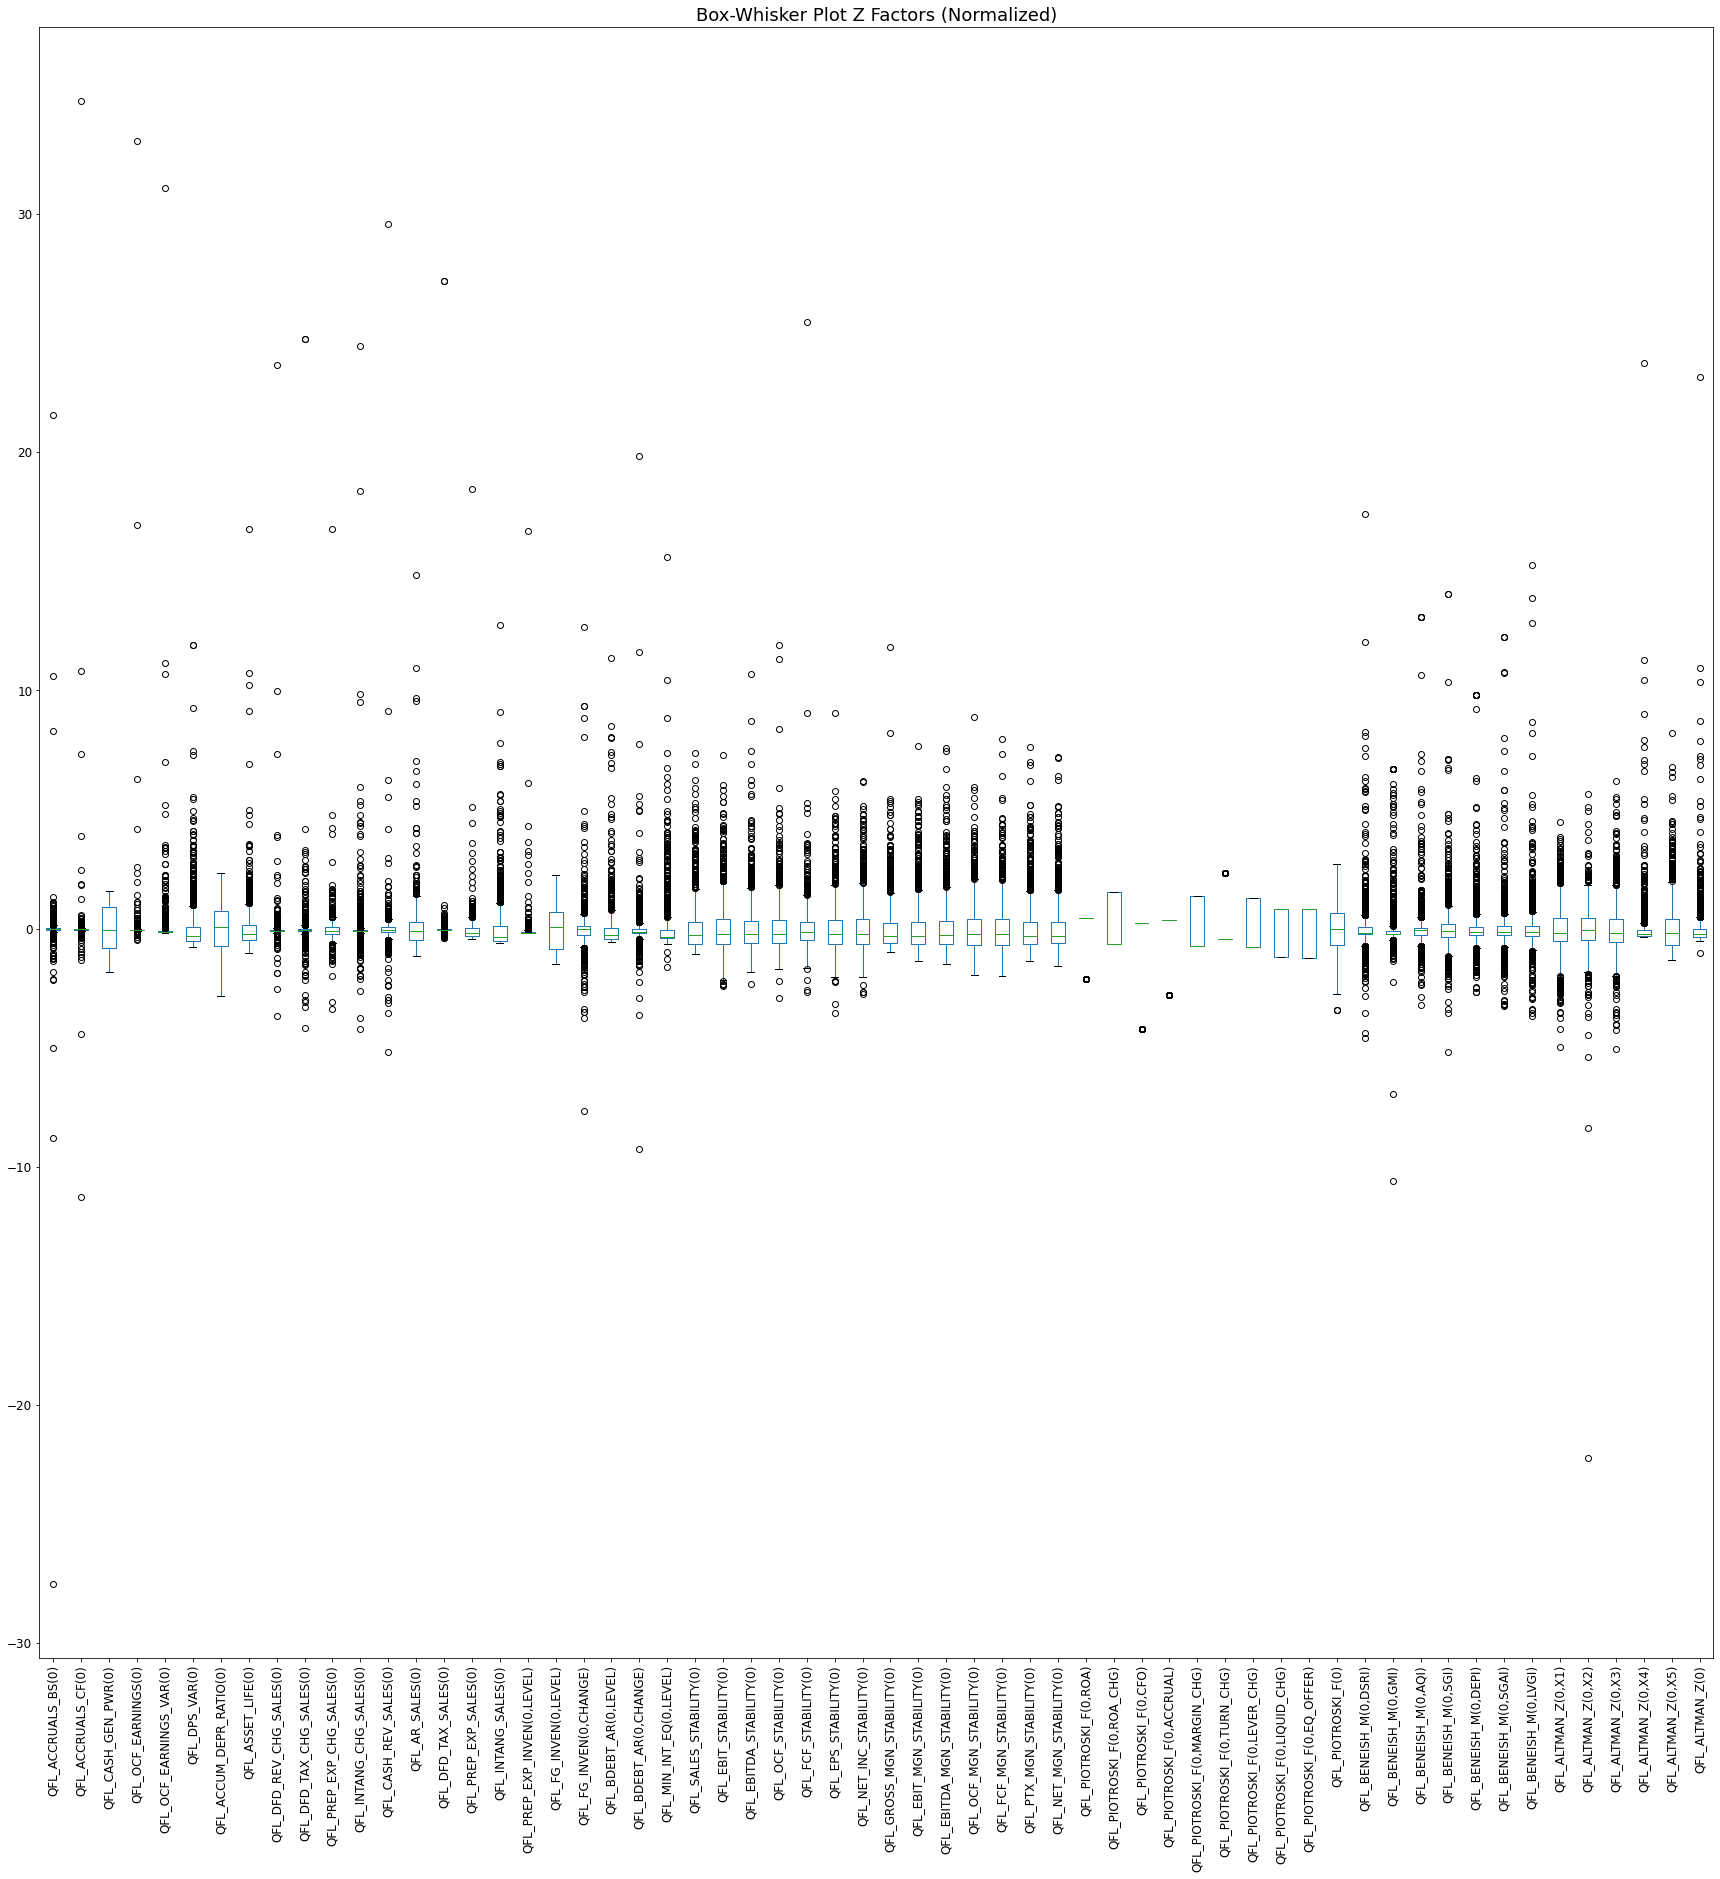

In [27]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [28]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,QFL_ACCRUALS_BS(0),QFL_ACCRUALS_CF(0),QFL_CASH_GEN_PWR(0),QFL_OCF_EARNINGS(0),QFL_OCF_EARNINGS_VAR(0),QFL_DPS_VAR(0),QFL_ACCUM_DEPR_RATIO(0),QFL_ASSET_LIFE(0),QFL_DFD_REV_CHG_SALES(0),QFL_DFD_TAX_CHG_SALES(0),QFL_PREP_EXP_CHG_SALES(0),QFL_INTANG_CHG_SALES(0),QFL_CASH_REV_SALES(0),QFL_AR_SALES(0),QFL_DFD_TAX_SALES(0),QFL_PREP_EXP_SALES(0),QFL_INTANG_SALES(0),"QFL_PREP_EXP_INVEN(0,LEVEL)","QFL_FG_INVEN(0,LEVEL)","QFL_FG_INVEN(0,CHANGE)","QFL_BDEBT_AR(0,LEVEL)","QFL_BDEBT_AR(0,CHANGE)","QFL_MIN_INT_EQ(0,LEVEL)",QFL_SALES_STABILITY(0),QFL_EBIT_STABILITY(0),QFL_EBITDA_STABILITY(0),QFL_OCF_STABILITY(0),QFL_FCF_STABILITY(0),QFL_EPS_STABILITY(0),QFL_NET_INC_STABILITY(0),QFL_GROSS_MGN_STABILITY(0),QFL_EBIT_MGN_STABILITY(0),QFL_EBITDA_MGN_STABILITY(0),QFL_OCF_MGN_STABILITY(0),QFL_FCF_MGN_STABILITY(0),QFL_PTX_MGN_STABILITY(0),QFL_NET_MGN_STABILITY(0),"QFL_PIOTROSKI_F(0,ROA)","QFL_PIOTROSKI_F(0,ROA_CHG)","QFL_PIOTROSKI_F(0,CFO)","QFL_PIOTROSKI_F(0,ACCRUAL)","QFL_PIOTROSKI_F(0,MARGIN_CHG)","QFL_PIOTROSKI_F(0,TURN_CHG)","QFL_PIOTROSKI_F(0,LEVER_CHG)","QFL_PIOTROSKI_F(0,LIQUID_CHG)","QFL_PIOTROSKI_F(0,EQ_OFFER)",QFL_PIOTROSKI_F(0),"QFL_BENEISH_M(0,DSRI)","QFL_BENEISH_M(0,GMI)","QFL_BENEISH_M(0,AQI)","QFL_BENEISH_M(0,SGI)","QFL_BENEISH_M(0,DEPI)","QFL_BENEISH_M(0,SGAI)","QFL_BENEISH_M(0,LVGI)","QFL_ALTMAN_Z(0,X1)","QFL_ALTMAN_Z(0,X2)","QFL_ALTMAN_Z(0,X3)","QFL_ALTMAN_Z(0,X4)","QFL_ALTMAN_Z(0,X5)",QFL_ALTMAN_Z(0),MFR
0,-27.497964,-11.266856,-1.832020,-0.481026,-0.176673,-0.789128,-2.814571,-1.00712,-3.651615,-4.161513,-3.356771,-4.204998,-5.182199,-1.157886,-0.385053,-0.440269,-0.59981,-0.188164,-1.473373,-7.637343,-0.5455,-9.231790,-1.604509,-1.080832,-2.386465,-2.331790,-2.902619,-2.659536,-3.556996,-2.738306,-0.958304,-1.337741,-1.480461,-1.945467,-1.991275,-1.360157,-1.557452,-2.13208,-0.642379,-4.191705,-2.77982,-0.727224,-0.429495,-0.783427,-1.187171,-1.223086,-3.414608,-4.570074,-10.606867,-3.198815,-5.165816,-2.639737,-3.236030,-3.644596,-4.958805,-22.208620,-5.059443,-0.329448,-1.314257,-1.002731,-3.390330
1,-8.789033,-4.416784,-1.831320,-0.440195,-0.176125,-0.789128,-2.810396,-1.00712,-2.520947,-3.290487,-3.076942,-3.757470,-3.532168,-1.157537,-0.375500,-0.440269,-0.59981,-0.188051,-1.473373,-3.736392,-0.5455,-3.611470,-1.285762,-1.080811,-2.354448,-1.822107,-2.209297,-2.588698,-3.167476,-2.673360,-0.895715,-1.310401,-1.243904,-1.646290,-1.960526,-1.303200,-1.441285,-2.13208,-0.642379,-4.191705,-2.77982,-0.727224,-0.429495,-0.783427,-1.187171,-1.223086,-3.414608,-4.358856,-6.920782,-2.854236,-3.534175,-2.639737,-3.217507,-3.535430,-4.213993,-8.353415,-4.245991,-0.329356,-1.159928,-0.515291,-2.315650
2,-4.990395,-1.306702,-1.827989,-0.334080,-0.176108,-0.789128,-2.701384,-1.00712,-1.874682,-3.061411,-1.989518,-2.626358,-3.117556,-1.157091,-0.352939,-0.440269,-0.59981,-0.187993,-1.473373,-3.513782,-0.5455,-2.916693,-0.966256,-1.080192,-2.312357,-1.774711,-1.689854,-2.148603,-2.226974,-2.650994,-0.894621,-1.285892,-1.223046,-1.579720,-1.861370,-1.276607,-1.397526,-2.13208,-0.642379,-4.191705,-2.77982,-0.727224,-0.429495,-0.783427,-1.187171,-1.223086,-3.414608,-3.537057,-2.250949,-2.361558,-3.357291,-2.472366,-3.186009,-3.407262,-3.736893,-5.375767,-4.059426,-0.329333,-1.157226,-0.502977,-1.910062
3,-2.135051,-1.190607,-1.827768,-0.278485,-0.175671,-0.789128,-2.701070,-1.00712,-1.847040,-3.010809,-1.489371,-2.101468,-2.976843,-1.149032,-0.307098,-0.439591,-0.59981,-0.187972,-1.473373,-3.513782,-0.5455,-2.245799,-0.646202,-1.079415,-2.215794,-1.737311,-1.562313,-1.683193,-2.182828,-2.367217,-0.889746,-1.261369,-1.219714,-1.555128,-1.686281,-1.265166,-1.395988,-2.13208,-0.642379,-4.191705,-2.77982,-0.727224,-0.429495,-0.783427,-1.187171,-1.223086,-2.733136,-2.844671,-1.342611,-2.309170,-3.084068,-2.464129,-3.162738,-3.385352,-3.547863,-4.443248,-4.014211,-0.329324,-1.157226,-0.492203,-1.735773
4,-2.114729,-1.059783,-1.820651,-0.258381,-0.175060,-0.789128,-2.690311,-1.00712,-1.427210,-2.803603,-1.352543,-1.980573,-2.874864,-1.143873,-0.278

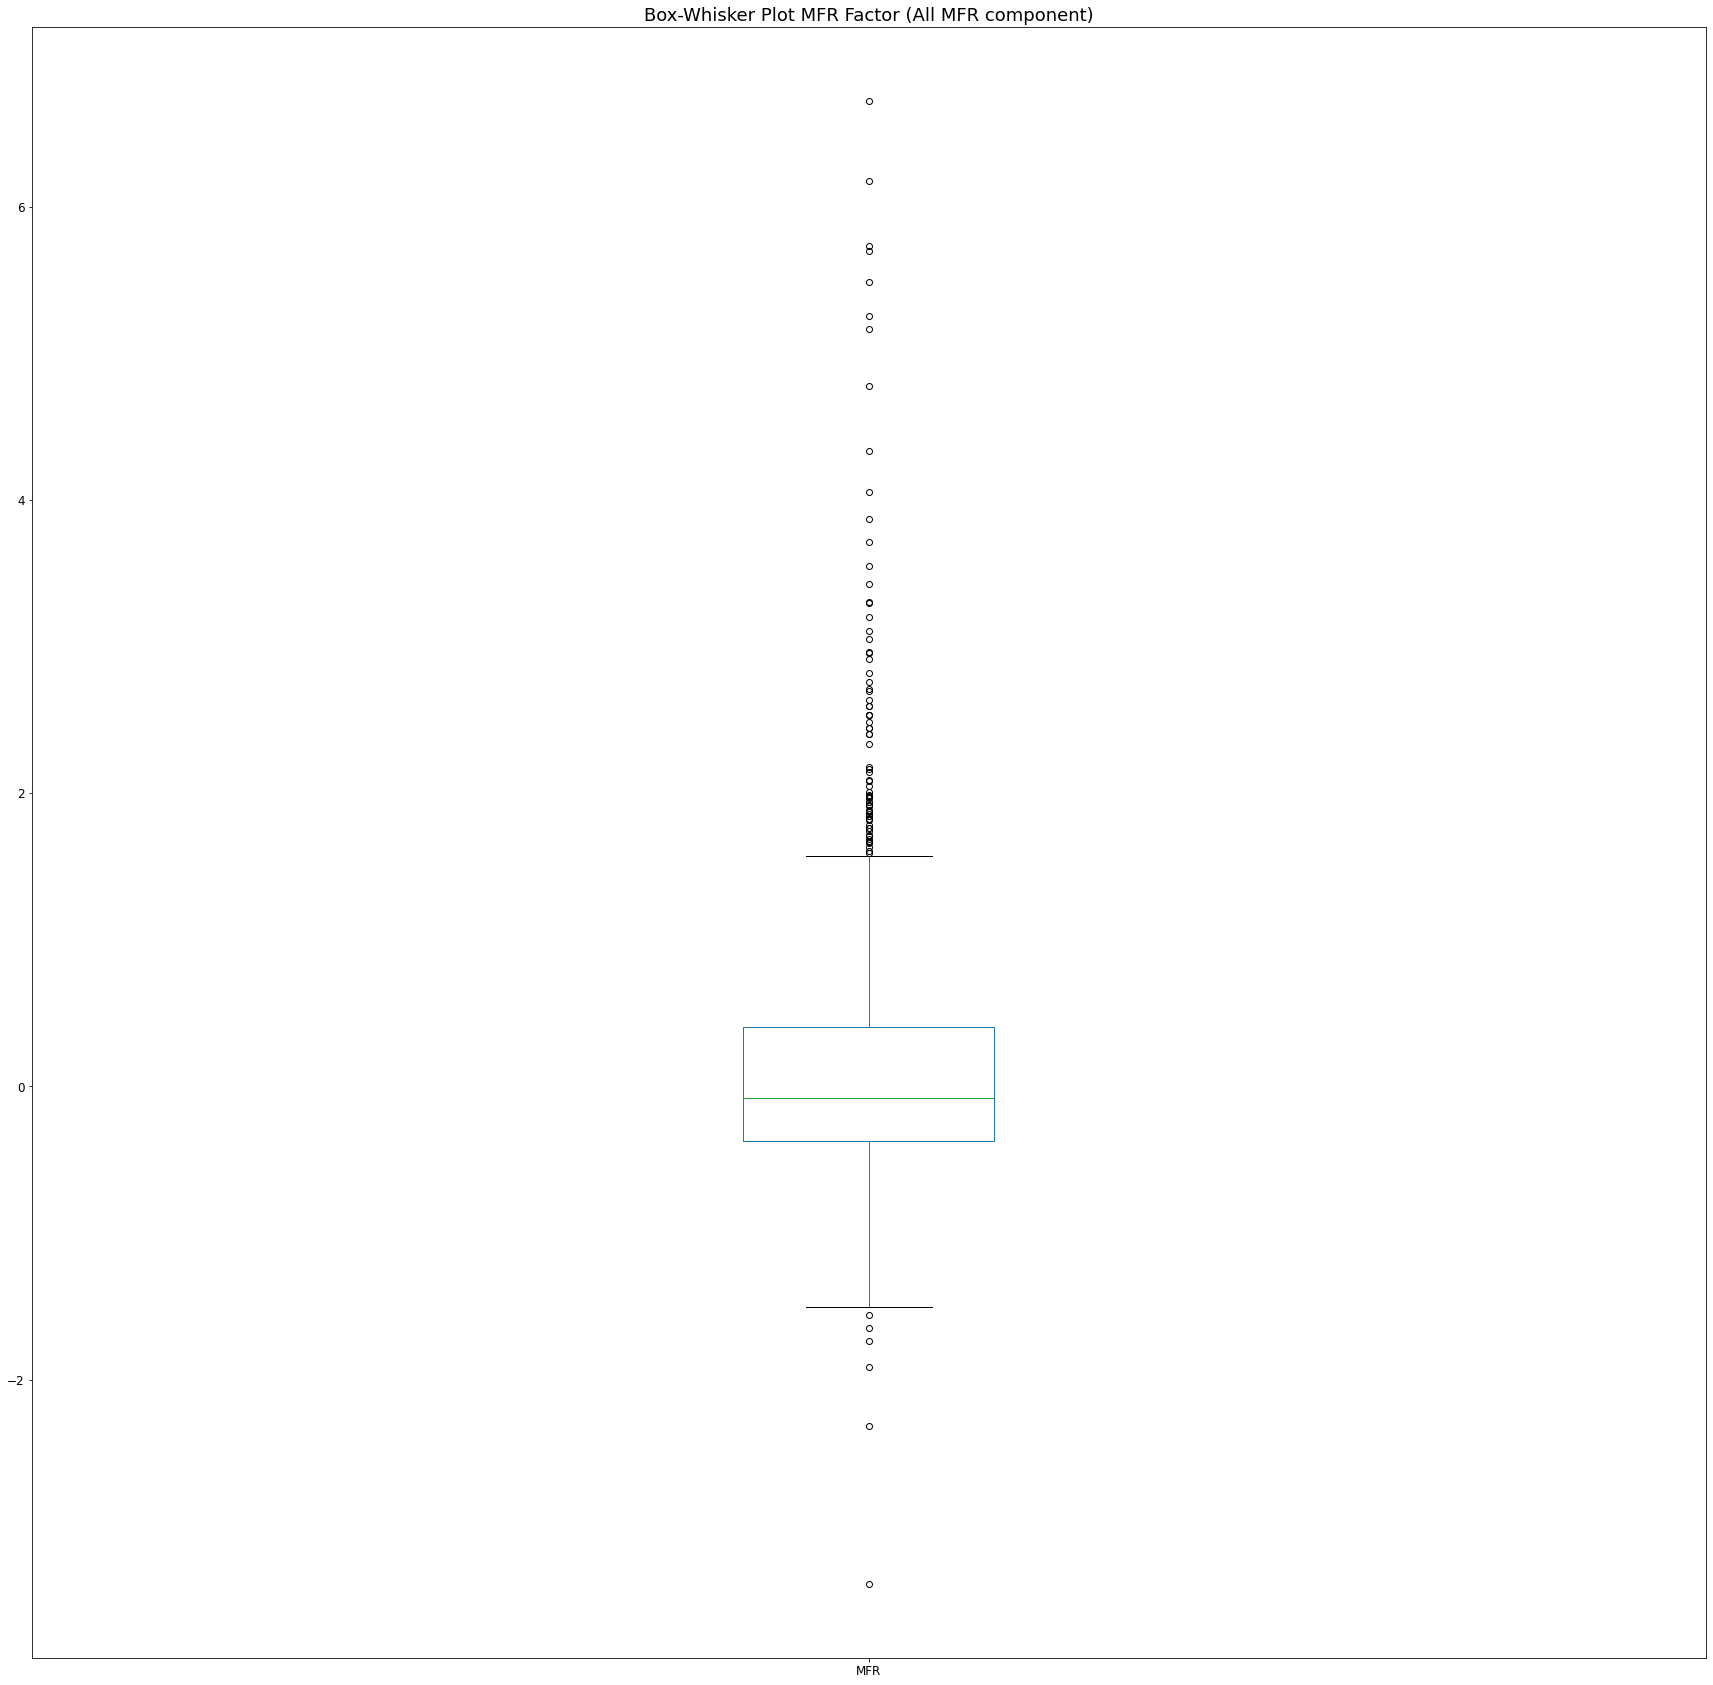

In [29]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

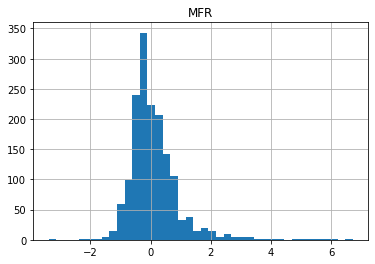

In [30]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [31]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


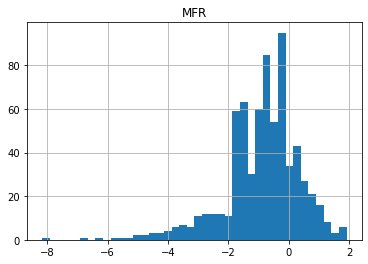

In [32]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [33]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,QFL_ACCRUALS_BS(0),QFL_ACCRUALS_CF(0),QFL_CASH_GEN_PWR(0),QFL_OCF_EARNINGS(0),QFL_OCF_EARNINGS_VAR(0),QFL_DPS_VAR(0),QFL_ACCUM_DEPR_RATIO(0),QFL_ASSET_LIFE(0),QFL_DFD_REV_CHG_SALES(0),QFL_DFD_TAX_CHG_SALES(0),QFL_PREP_EXP_CHG_SALES(0),QFL_INTANG_CHG_SALES(0),QFL_CASH_REV_SALES(0),QFL_AR_SALES(0),QFL_DFD_TAX_SALES(0),QFL_PREP_EXP_SALES(0),QFL_INTANG_SALES(0),"QFL_PREP_EXP_INVEN(0,LEVEL)","QFL_FG_INVEN(0,LEVEL)","QFL_FG_INVEN(0,CHANGE)","QFL_BDEBT_AR(0,LEVEL)","QFL_BDEBT_AR(0,CHANGE)","QFL_MIN_INT_EQ(0,LEVEL)",QFL_SALES_STABILITY(0),QFL_EBIT_STABILITY(0),QFL_EBITDA_STABILITY(0),QFL_OCF_STABILITY(0),QFL_FCF_STABILITY(0),QFL_EPS_STABILITY(0),QFL_NET_INC_STABILITY(0),QFL_GROSS_MGN_STABILITY(0),QFL_EBIT_MGN_STABILITY(0),QFL_EBITDA_MGN_STABILITY(0),QFL_OCF_MGN_STABILITY(0),QFL_FCF_MGN_STABILITY(0),QFL_PTX_MGN_STABILITY(0),QFL_NET_MGN_STABILITY(0),"QFL_PIOTROSKI_F(0,ROA)","QFL_PIOTROSKI_F(0,ROA_CHG)","QFL_PIOTROSKI_F(0,CFO)","QFL_PIOTROSKI_F(0,ACCRUAL)","QFL_PIOTROSKI_F(0,MARGIN_CHG)","QFL_PIOTROSKI_F(0,TURN_CHG)","QFL_PIOTROSKI_F(0,LEVER_CHG)","QFL_PIOTROSKI_F(0,LIQUID_CHG)","QFL_PIOTROSKI_F(0,EQ_OFFER)",QFL_PIOTROSKI_F(0),"QFL_BENEISH_M(0,DSRI)","QFL_BENEISH_M(0,GMI)","QFL_BENEISH_M(0,AQI)","QFL_BENEISH_M(0,SGI)","QFL_BENEISH_M(0,DEPI)","QFL_BENEISH_M(0,SGAI)","QFL_BENEISH_M(0,LVGI)","QFL_ALTMAN_Z(0,X1)","QFL_ALTMAN_Z(0,X2)","QFL_ALTMAN_Z(0,X3)","QFL_ALTMAN_Z(0,X4)","QFL_ALTMAN_Z(0,X5)",QFL_ALTMAN_Z(0)
0,-1.324638,-19.084040,-0.994666,1.405201,-2.566863,0.148912,-0.518251,4.100579,0.004089,NaN,NaN,NaN,0.028505,0.058800,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,2.475109,18.206644,19.757082,12.370102,8.683401,6.062143,10.857952,133.498350,17.864166,17.009910,19.802406,15.859110,14.831958,32.152170,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,7.0,0.950279,0.990645,0.018692,1.054553,0.798388,1.064003,0.116973,0.118316,0.046207,0.199111,2.036898,0.835433,6.299241
1,21.217370,-4.614842,-0.879361,1.393633,-0.620933,0.131032,-0.812913,5.217399,0.015491,-0.000319,NaN,0.008103,-0.010145,0.155329,0.001271,NaN,0.345399,NaN,0.675046,-0.057982,0.026001,0.010374,0.000000,1.584227,2.605282,2.887545,4.422132,4.588669,1.451108,1.497250,25.217669,5.039925,6.013425,16.654833,12.367548,4.786670,2.844990,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,8.0,1.008459,0.973946,-0.073221,1.135446,0.892149,0.958112,-0.038570,0.355550,0.130209,0.193683,2.215059,0.507461,7.252739
2,24.332981,8.749453,-0.703610,3.181907,1.943672,NaN,-1.125883,6.458482,0.000776,NaN,NaN,0.000650,-0.021865,0.059081,NaN,NaN,0.042995,NaN,1.000000,0.000000,0.044971,-0.005225,0.000000,1.008145,1.117816,1.613064,1.526842,1.345189,1.013005,0.991330,13.481634,2.330737,4.454567,6.280461,4.020551,2.112599,1.674056,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,6.0,0.970639,1.022011,-0.166782,1.310689,0.865203,0.965704,-0.017175,0.039184,0.160639,0.085964,2.084465,1.466792,6.846563
3,36.223390,29.137615,NaN,1.452186,-0.900243,NaN,-1.538844,8.607321,0.001773,-0.015321,NaN,0.007395,-0.002676,0.101600,0.045330,NaN,0.250393,NaN,NaN,NaN,0.037313,-0.000435,0.000000,0.841471,3.074652,3.066902,2.892207,3.210056,2.704802,2.730525,41.957497,7.073074,9.530758,9.742354,4.670195,7.073074,5.225036,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,7.0,0.954083,1.010016,0.126072,1.187091,0.836788,1.120185,-0.163582,0.367769,0.467867,0.210716,3.316551,0.578754,18.909523
4,20.330269,9.035897,-1.221126,1.592529,-0.547175,NaN,-1.229992,7.517834,0.004159,-0.001062,NaN,0.015014,-0.019573,0.145390,0.005839,NaN,0.130603,NaN,1.000000,0.000000,0.032377,-0.001345,0.000000,1.304977,4.308945,3.953307,4.100932,5.419632,2.572243,2.553835,21.062155,15.692030,21.657135,15.311814,4.754495,15.869806,6.006453,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,1.032046,1.036741,0.033733,1.109116,0.952566,1.003254,0.192938,0.388210,0.519868,0.124344,2.640959,0.616632,10.636624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

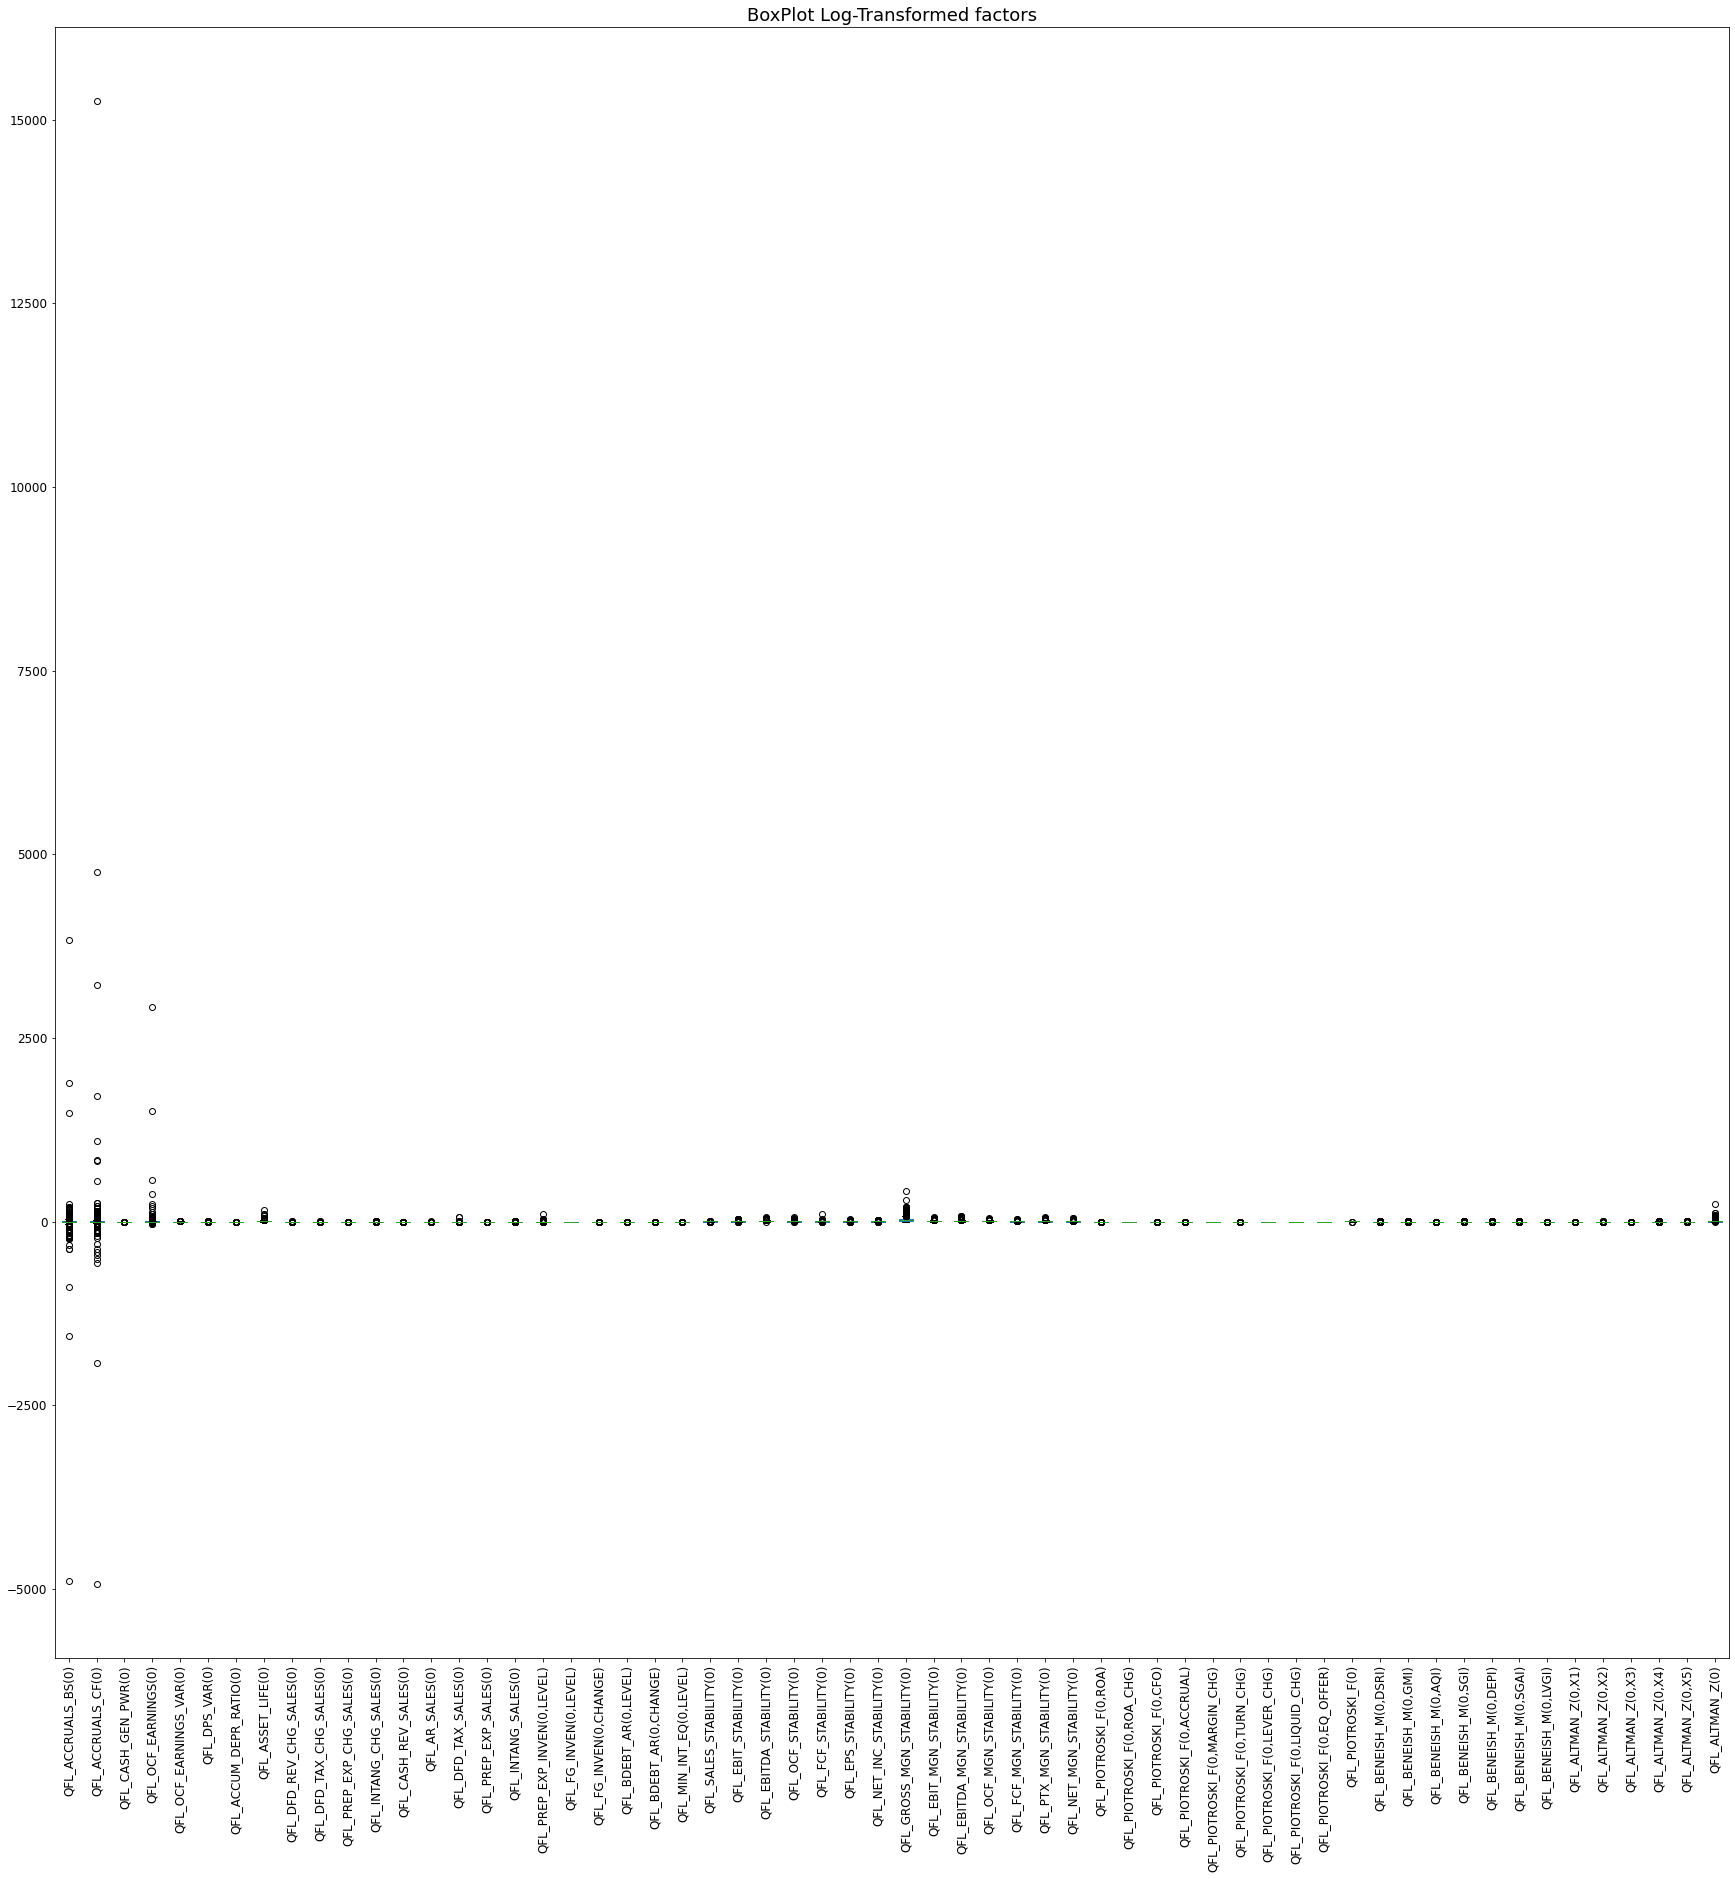

In [34]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [35]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,QFL_ACCRUALS_BS(0),QFL_ACCRUALS_CF(0),QFL_CASH_GEN_PWR(0),QFL_OCF_EARNINGS(0),QFL_OCF_EARNINGS_VAR(0),QFL_DPS_VAR(0),QFL_ACCUM_DEPR_RATIO(0),QFL_ASSET_LIFE(0),QFL_DFD_REV_CHG_SALES(0),QFL_DFD_TAX_CHG_SALES(0),QFL_PREP_EXP_CHG_SALES(0),QFL_INTANG_CHG_SALES(0),QFL_CASH_REV_SALES(0),QFL_AR_SALES(0),QFL_DFD_TAX_SALES(0),QFL_PREP_EXP_SALES(0),QFL_INTANG_SALES(0),"QFL_PREP_EXP_INVEN(0,LEVEL)","QFL_FG_INVEN(0,LEVEL)","QFL_FG_INVEN(0,CHANGE)","QFL_BDEBT_AR(0,LEVEL)","QFL_BDEBT_AR(0,CHANGE)","QFL_MIN_INT_EQ(0,LEVEL)",QFL_SALES_STABILITY(0),QFL_EBIT_STABILITY(0),QFL_EBITDA_STABILITY(0),QFL_OCF_STABILITY(0),QFL_FCF_STABILITY(0),QFL_EPS_STABILITY(0),QFL_NET_INC_STABILITY(0),QFL_GROSS_MGN_STABILITY(0),QFL_EBIT_MGN_STABILITY(0),QFL_EBITDA_MGN_STABILITY(0),QFL_OCF_MGN_STABILITY(0),QFL_FCF_MGN_STABILITY(0),QFL_PTX_MGN_STABILITY(0),QFL_NET_MGN_STABILITY(0),"QFL_PIOTROSKI_F(0,ROA)","QFL_PIOTROSKI_F(0,ROA_CHG)","QFL_PIOTROSKI_F(0,CFO)","QFL_PIOTROSKI_F(0,ACCRUAL)","QFL_PIOTROSKI_F(0,MARGIN_CHG)","QFL_PIOTROSKI_F(0,TURN_CHG)","QFL_PIOTROSKI_F(0,LEVER_CHG)","QFL_PIOTROSKI_F(0,LIQUID_CHG)","QFL_PIOTROSKI_F(0,EQ_OFFER)",QFL_PIOTROSKI_F(0),"QFL_BENEISH_M(0,DSRI)","QFL_BENEISH_M(0,GMI)","QFL_BENEISH_M(0,AQI)","QFL_BENEISH_M(0,SGI)","QFL_BENEISH_M(0,DEPI)","QFL_BENEISH_M(0,SGAI)","QFL_BENEISH_M(0,LVGI)","QFL_ALTMAN_Z(0,X1)","QFL_ALTMAN_Z(0,X2)","QFL_ALTMAN_Z(0,X3)","QFL_ALTMAN_Z(0,X4)","QFL_ALTMAN_Z(0,X5)",QFL_ALTMAN_Z(0),MFR
0,-0.019452,-0.074612,-0.140106,-0.067876,-1.699549,-0.330403,0.773375,-0.565706,-0.066879,NaN,NaN,NaN,0.250102,-0.747962,NaN,NaN,NaN,NaN,1.636751,-0.017861,NaN,NaN,-0.409439,0.299901,2.852447,2.434559,1.669056,1.433660,0.724850,2.057771,3.215164,1.461010,0.781709,2.509791,3.249546,1.243794,5.140452,0.468732,1.555740,0.238417,0.35951,1.374231,2.326861,-0.783427,-1.187171,0.817093,1.355694,-0.397347,-0.230580,0.150422,0.175422,-0.652923,0.053565,0.463426,0.079692,-0.430303,1.699054,0.962036,0.544884,0.165293,0.719655
1,0.107231,-0.041635,-0.011473,-0.068007,-0.215138,-0.385483,0.138376,-0.445484,-0.012510,-0.038192,NaN,-0.067073,-0.176194,-0.075011,-0.057753,NaN,-0.213897,NaN,0.626104,-0.813189,-0.235614,0.058778,-0.409439,-0.745925,-0.500033,-0.576652,-0.092715,0.428412,-0.594845,-0.598995,-0.111839,-0.250032,-0.366676,1.926467,2.337792,-0.184803,-0.352904,0.468732,1.555740,0.238417,0.35951,1.374231,2.326861,1.275645,-1.187171,0.817093,2.037165,-0.141875,-0.259504,-0.266724,0.459979,-0.419596,-0.273820,-0.272076,1.271947,-0.227324,1.630422,1.070863,-0.124386,0.256870,0.174608
2,0.124740,-0.011176,0.184592,-0.047752,1.741214,NaN,-0.536076,-0.311885,-0.082677,NaN,NaN,-0.086336,-0.305461,-0.746003,NaN,NaN,-0.551772,NaN,1.636751,-0.017861,-0.009525,-0.257489,-0.409439,-1.422199,-0.819666,-0.804147,-0.734494,-0.367855,-0.720232,-0.742586,-0.472438,-0.611498,-0.529470,0.003838,0.158134,-0.565098,-0.572384,0.468732,1.555740,0.238417,0.35951,-0.727224,-0.429495,1.275645,0.841812,-1.223086,0.674222,-0.307945,-0.176251,-0.691344,1.076430,-0.486652,-0.250348,-0.170905,-0.317998,-0.153794,0.268402,0.991091,1.833256,0.217860,-0.055929
3,0.191562,0.035290,NaN,-0.067344,-0.428204,NaN,-1.426013,-0.080569,-0.077923,-0.132366,NaN,-0.068903,-0.093806,-0.449582,-0.038796,NaN,-0.320047,NaN,NaN,NaN,-0.100795,-0.160373,-0.409439,-1.617862,-0.399173,-0.544637,-0.431843,0.089966,-0.236033,-0.248966,0.402504,0.021236,0.000646,0.645413,0.327776,0.140359,0.093214,0.468732,1.555740,0.238417,0.35951,-0.727224,-0.429495,1.275645,0.841812,0.817093,1.355694,-0.380643,-0.197028,0.637760,0.641650,-0.557363,0.227264,-0.863206,1.333355,0.588580,1.845790,1.743695,0.021097,1.376428,0.128087
4,0.102245,-0.010524,-0.392741,-0.065754,-0.158874,NaN,-0.760432,-0.197849,-0.066545,-0.042856,NaN,-0.049211,-0.280181,-0.144300,-0.055788,NaN,-0.453888,NaN,1.636751,-0.017861,-0.159623,-0.178823,-0.409439,-1.073742,-0.133944,-0.386414,-0.163914,0.632412,-0.273972,-0.299114,-0.239521,1.171198,1.267028,1.677572,0.349790,1.391392,0.239683,0.468732,-0.642379,0.238417,0.35951,-0.727224

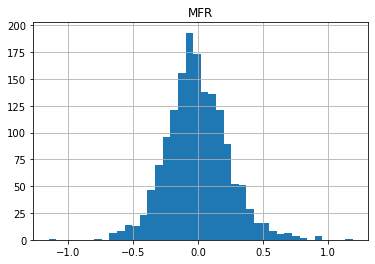

In [36]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [37]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: 0.13
Information Coefficient (P-Value): 0.0


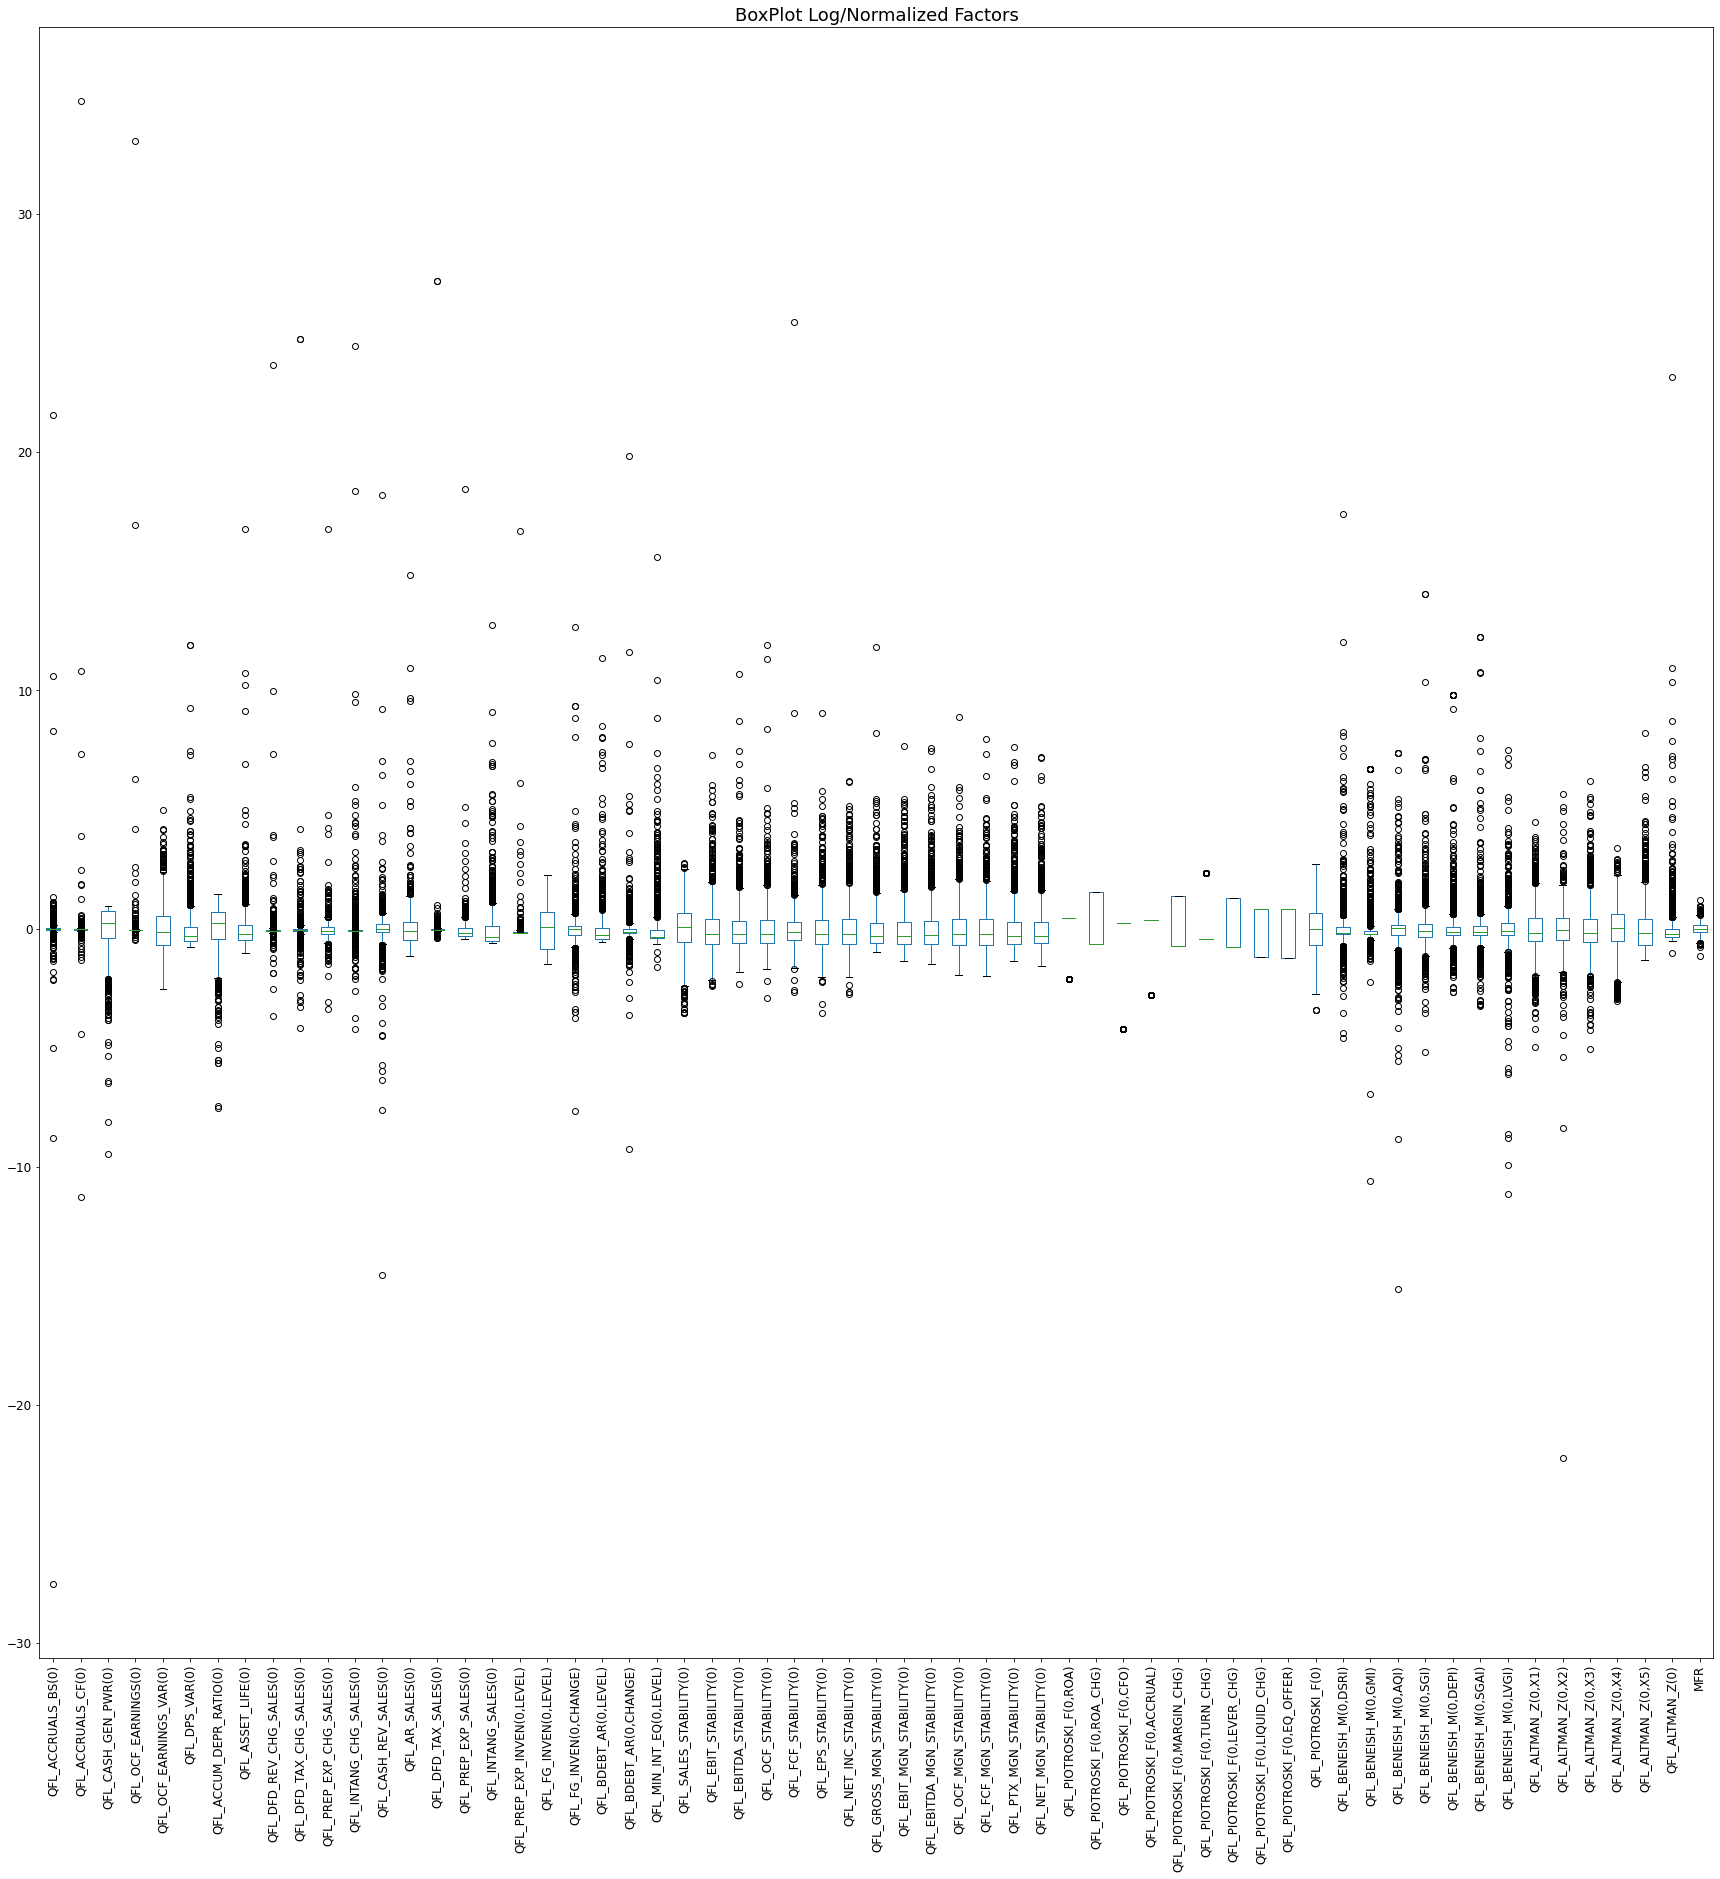

In [38]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [39]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_ACCRUALS_BS(0),QFL_ACCRUALS_CF(0),QFL_CASH_GEN_PWR(0),QFL_EFDR(0),QFL_EFR(0),QFL_OCF_EARNINGS(0),QFL_OCF_EARNINGS_VAR(0),QFL_DPS_VAR(0),QFL_ACCUM_DEPR_RATIO(0),QFL_ASSET_LIFE(0),QFL_DFD_REV_CHG_SALES(0),QFL_AR_CHG_SALES(0),QFL_DFD_TAX_CHG_SALES(0),QFL_PREP_EXP_CHG_SALES(0),QFL_INTANG_CHG_SALES(0),QFL_CASH_REV_SALES(0),QFL_AR_SALES(0),QFL_DFD_TAX_SALES(0),QFL_PREP_EXP_SALES(0),QFL_INTANG_SALES(0),"QFL_PREP_EXP_INVEN(0,LEVEL)","QFL_PREP_EXP_INVEN(0,CHANGE)","QFL_FG_INVEN(0,LEVEL)","QFL_FG_INVEN(0,CHANGE)","QFL_BDEBT_AR(0,LEVEL)","QFL_BDEBT_AR(0,CHANGE)","QFL_MIN_INT_EQ(0,LEVEL)","QFL_MIN_INT_EQ(0,CHANGE)",QFL_SALES_STABILITY(0),QFL_EBIT_STABILITY(0),QFL_EBITDA_STABILITY(0),QFL_OCF_STABILITY(0),QFL_FCF_STABILITY(0),QFL_EPS_STABILITY(0),QFL_NET_INC_STABILITY(0),QFL_GROSS_MGN_STABILITY(0),QFL_EBIT_MGN_STABILITY(0),QFL_EBITDA_MGN_STABILITY(0),QFL_OCF_MGN_STABILITY(0),QFL_FCF_MGN_STABILITY(0),QFL_PTX_MGN_STABILITY(0),QFL_NET_MGN_STABILITY(0),"QFL_PIOTROSKI_F(0,ROA)","QFL_PIOTROSKI_F(0,ROA_CHG)","QFL_PIOTROSKI_F(0,CFO)","QFL_PIOTROSKI_F(0,ACCRUAL)","QFL_PIOTROSKI_F(0,MARGIN_CHG)","QFL_PIOTROSKI_F(0,TURN_CHG)","QFL_PIOTROSKI_F(0,LEVER_CHG)","QFL_PIOTROSKI_F(0,LIQUID_CHG)","QFL_PIOTROSKI_F(0,EQ_OFFER)",QFL_PIOTROSKI_F(0),"QFL_BENEISH_M(0,DSRI)","QFL_BENEISH_M(0,GMI)","QFL_BENEISH_M(0,AQI)","QFL_BENEISH_M(0,SGI)","QFL_BENEISH_M(0,DEPI)","QFL_BENEISH_M(0,SGAI)","QFL_BENEISH_M(0,LVGI)","QFL_BENEISH_M(0,TATA)",QFL_BENEISH_M(0),"QFL_ALTMAN_Z(0,X1)","QFL_ALTMAN_Z(0,X2)","QFL_ALTMAN_Z(0,X3)","QFL_ALTMAN_Z(0,X4)","QFL_ALTMAN_Z(0,X5)",QFL_ALTMAN_Z(0),ison_screen
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,-1.324638,-19.084040,0.369847,-0.294244,-0.517136,1.405201,0.076776,0.148912,0.595561,4.100579,0.004089,-0.024826,NaN,NaN,NaN,1.028915,0.058800,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.0,0.0,11.882999,18.206644,19.757082,12.370102,8.683401,6.062143,10.857952,133.498350,17.864166,17.009910,19.802406,15.859110,14.831958,32.152170,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,7.0,0.950279,0.990645,1.018868,1.054553,0.798388,1.064003,1.124089,-0.070891,-2.882144,0.118316,0.046207,0.199111,7.666787,0.835433,6.299241,1
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,21.217370,-4.614842,0.415048,-0.146664,-0.373098,1.393633,0.537443,0.131032,0.443564,5.217399,0.015491,0.025586,-0.000319,NaN,0.008103,0.989906,0.155329,0.001271,NaN,0.345399,NaN,NaN,0.675046,-0.057982,0.026001,0.010374,0.0,0.0,4.875520,2.605282,2.887545,4.422132,4.588669,1.451108,1.497250,25.217669,5.039925,6.013425,16.654833,12.367548,4.786670,2.844990,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,8.0,1.008459,0.973946,0.929395,1.135446,0.892149,0.958112,0.962164,-0.064491,-2.689420,0.355550,0.130209,0.193683,9.161954,0.507461,7.252739,1
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,24.332981,8.749453,0.494796,0.098476,-0.206078,3.181907,6.984347,NaN,0.324366,6.458482,0.000776,0.011416,NaN,NaN,0.000650,0.978372,0.059081,NaN,NaN,0.042995,NaN,NaN,1.000000,0.000000,0.044971,-0.005225,0.0,0.0,2.740514,1.117816,1.613064,1.526842,1.345189,1.013005,0.991330,13.481634,2.330737,4.454567,6.280461,4.020551,2.112599,1.674056,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,6.0,0.970639,1.022011,0.846384,1.310689,0.865203,0.965704,0.982972,-0.159833,-3.035089,0.039184,0.160639,0.085964,8.040289,1.466792,6.846563,1
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,36.223390,29.137615,NaN,-0.100282,-0.332764,1.452186,0.406471,NaN,0.214629,8.607321,0.001773,0.004444,-0.015321,NaN,0.007395,0.997328,0.101600,0.045330,NaN,0.250393,NaN,NaN,NaN,NaN,0.037313,-0.000435,0.0,0.0,2.319777,3.074652,3.066902,2.892207,3.

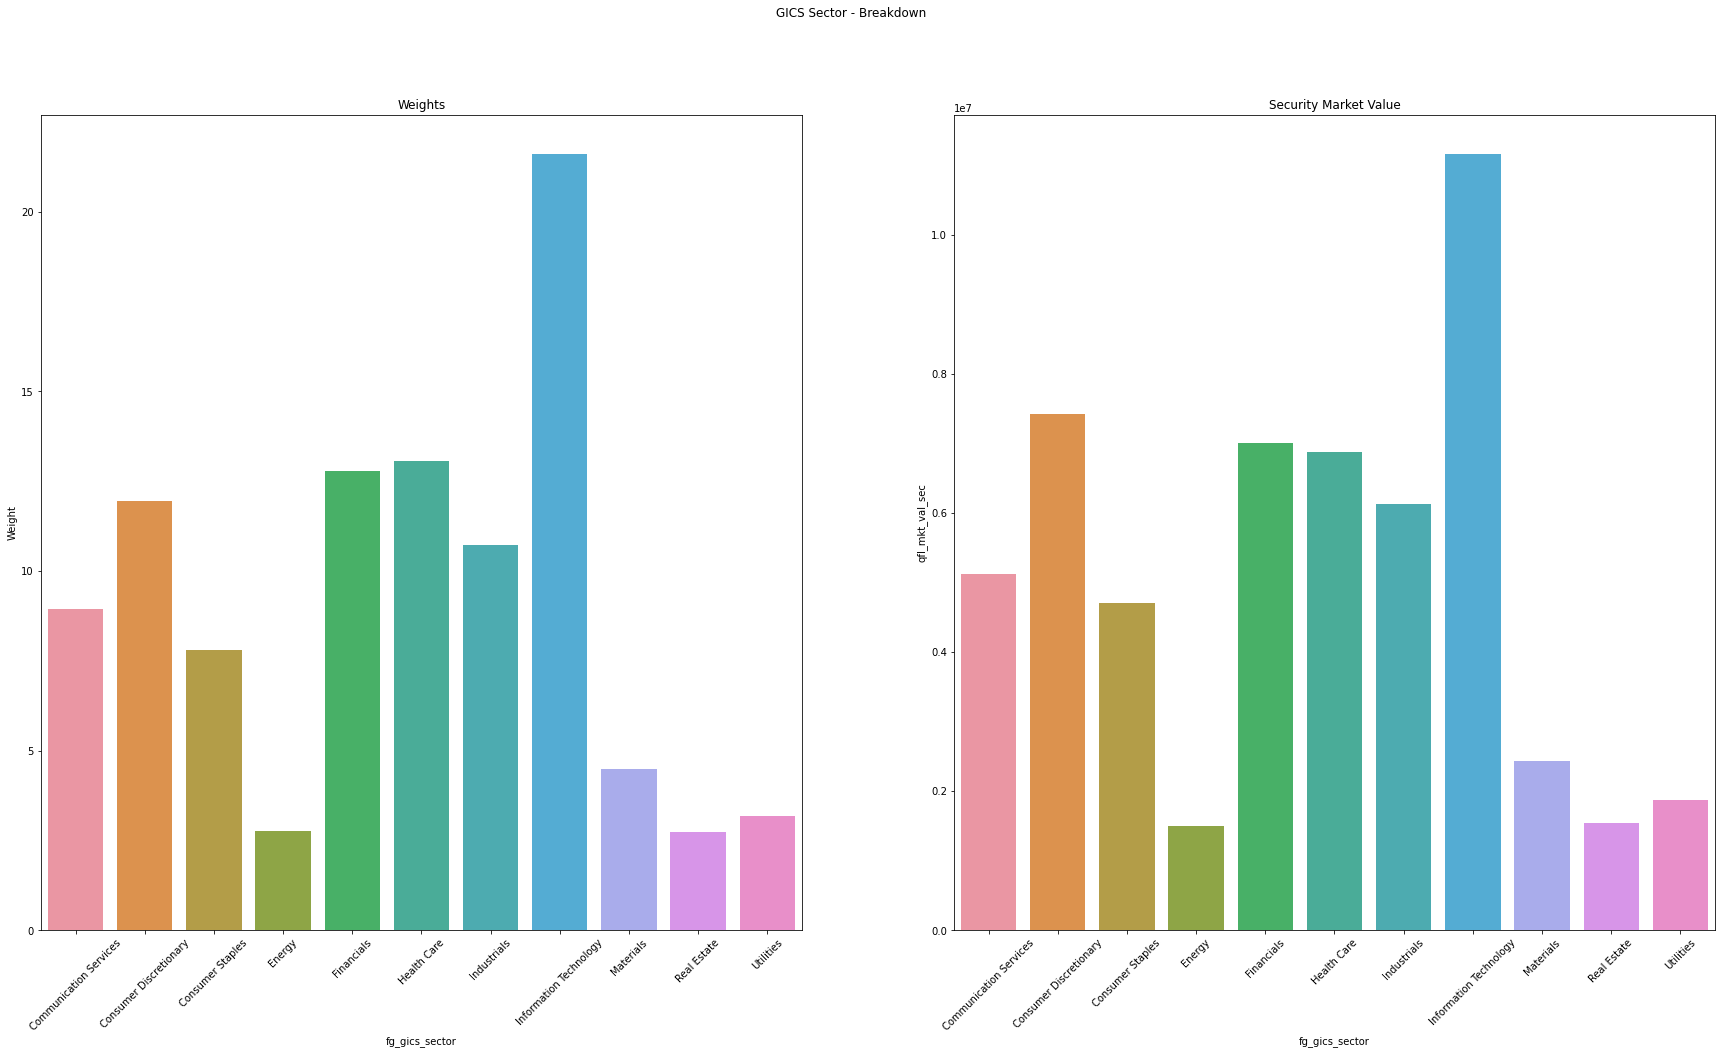

In [40]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

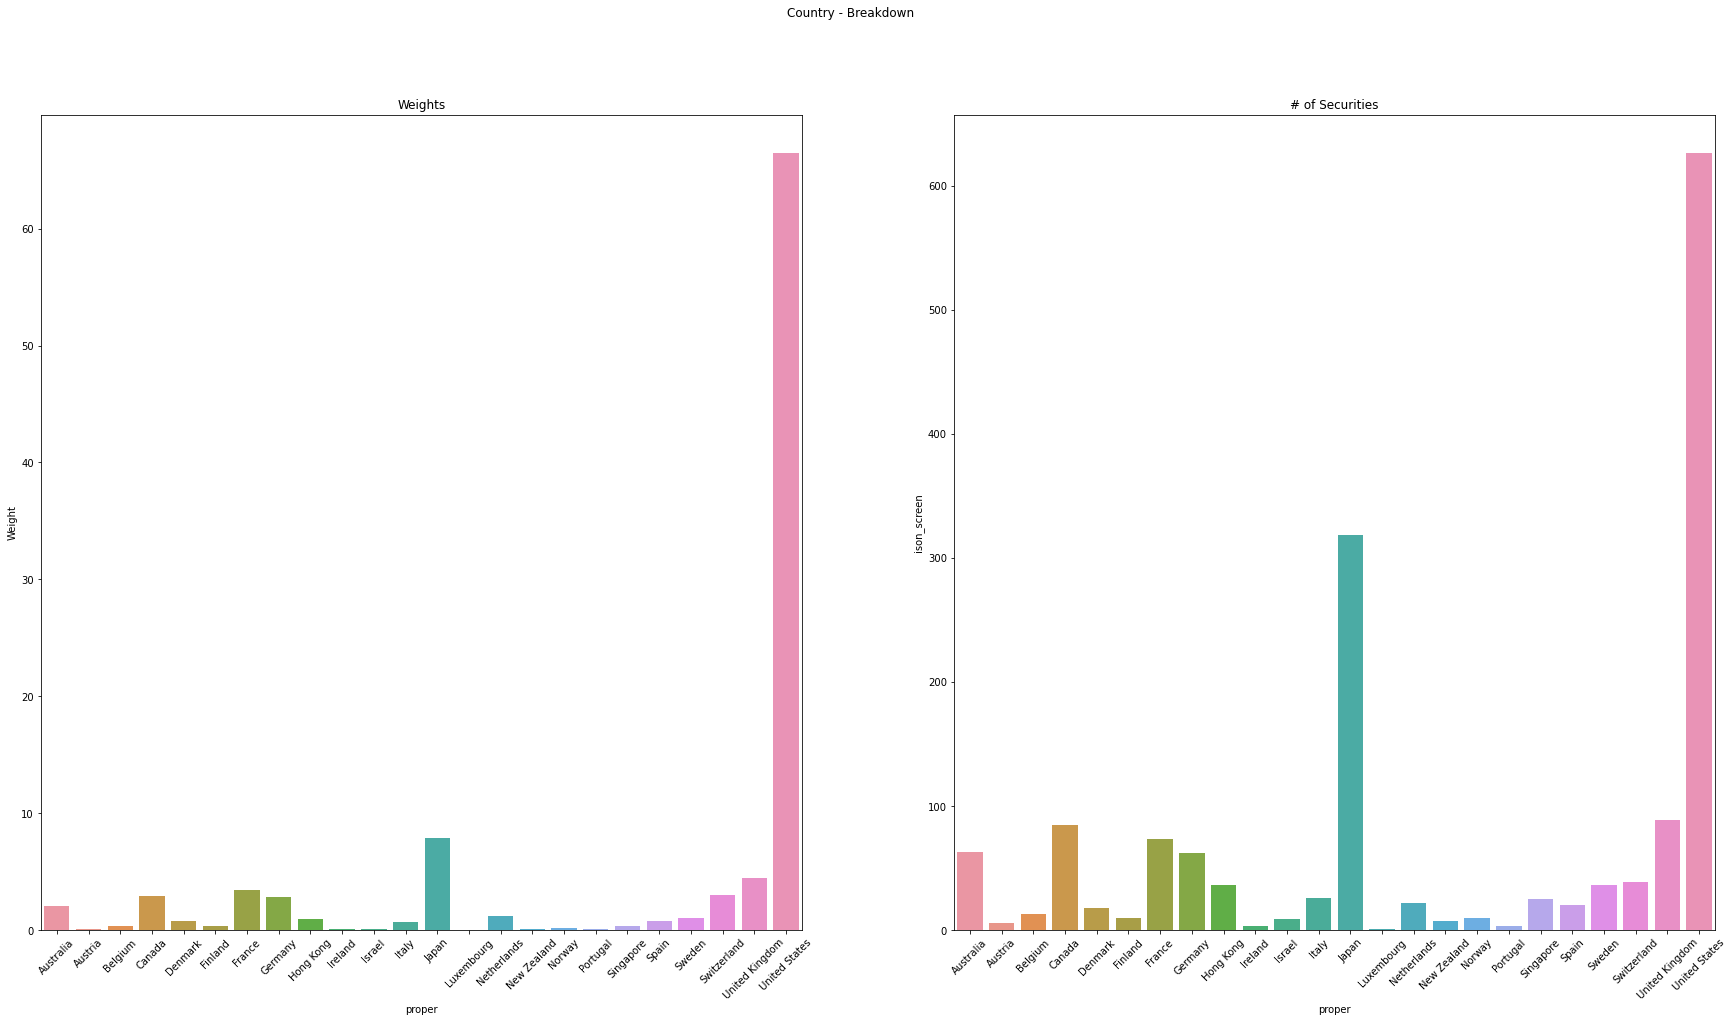

In [41]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

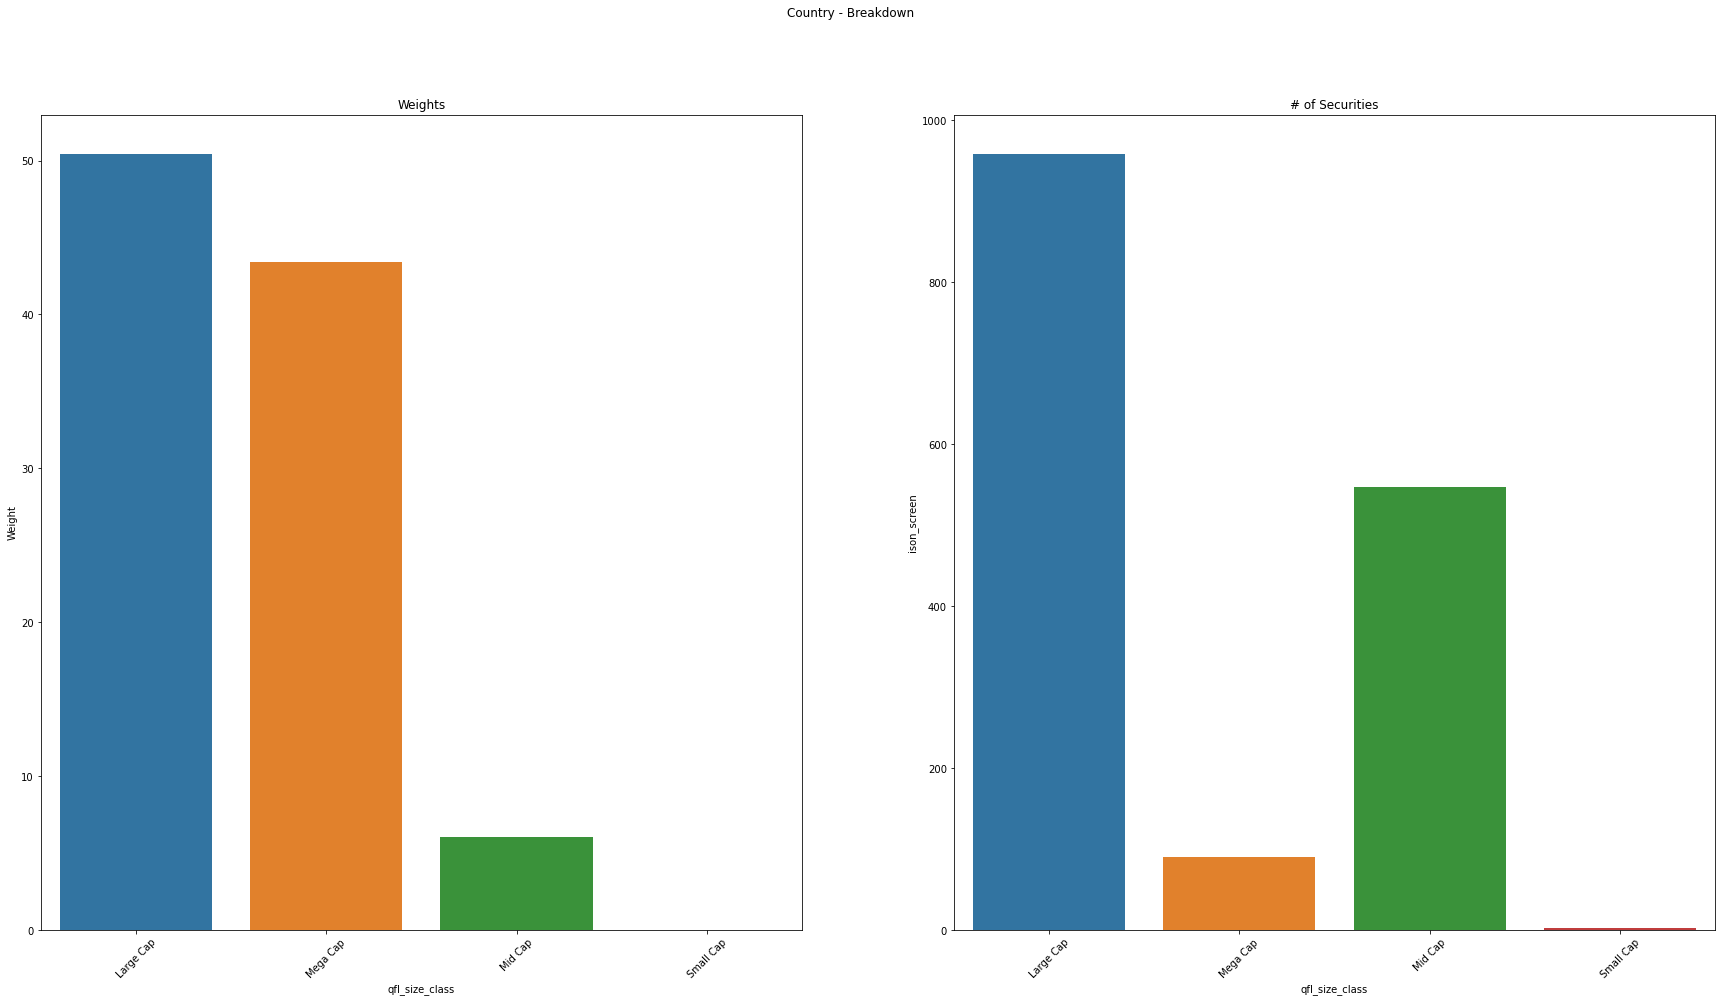

In [42]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [43]:
# Feature Selection

In [44]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [45]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-45-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [46]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


Num Features: 3
Selected Features: [False False False False False  True False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False]
Feature Ranking: [ 3  5 18 16 14  1  4 13 20 21  1 22  2 26 28 30 32 34 36 38 39 37 35 33
 31 29 27 25 19 17 15 12 11 10  9  8  7  6  1 23 24]


In [47]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_SALES_STABILITY(0)', 'QFL_EPS_STABILITY(0)', 'QFL_ALTMAN_Z(0,X4)'], dtype='object')

In [48]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,QFL_SALES_STABILITY(0),QFL_EPS_STABILITY(0),"QFL_ALTMAN_Z(0,X4)"
QFL_SALES_STABILITY(0),1.000000,0.279709,-0.139445
QFL_EPS_STABILITY(0),0.279709,1.000000,-0.045047
"QFL_ALTMAN_Z(0,X4)",-0.139445,-0.045047,1.000000


In [49]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

,QFL_SALES_STABILITY(0),QFL_EPS_STABILITY(0),"QFL_ALTMAN_Z(0,X4)"
0,11.882999,6.062143,7.666787
1,4.875520,1.451108,9.161954
2,2.740514,1.013005,8.040289
3,2.319777,2.704802,27.565115
4,3.687606,2.572243,14.026646
...,...,...,...
1595,19.164705,4.659447,0.822754
1596,10.869376,4.720225,0.302265
1597,22.428352,2.466595,0.613269
1598,9.560201,0.449948,0.256989


In [50]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,QFL_SALES_STABILITY(0),QFL_EPS_STABILITY(0),"QFL_ALTMAN_Z(0,X4)",MFR
0,-0.082379,0.726442,0.122182,0.255415
1,-0.695124,-0.596151,0.210428,-0.360282
2,-0.881813,-0.721813,0.144226,-0.486467
3,-0.918603,-0.236551,1.296609,0.047152
4,-0.798998,-0.274574,0.497549,-0.192007


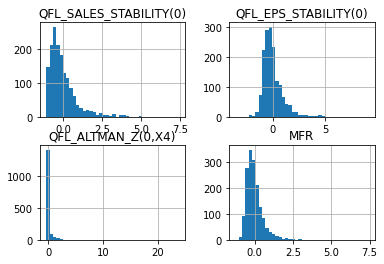

In [51]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [52]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.21
Information Coefficient (P-Value): 0.0


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [53]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.21
Information Coefficient (P-Value): 0.0


### Z-Score + Log-Transformation (All Components)

In [54]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: 0.13
Information Coefficient (P-Value): 0.0


### Z-Score Only (All Components)

In [55]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04
